<a href="https://colab.research.google.com/github/rkp74/Predicting-vehicle-trim-and-dealer-listing-prices/blob/main/Predicting_vehicle_trim_and_dealer_listing_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
import hyperopt

In [ ]:
from xgboost.sklearn import (XGBClassifier , XGBRegressor)

In [ ]:
from sklearn.metrics import (r2_score , mean_squared_error , mean_absolute_error , median_absolute_error ,
                             roc_auc_score , auc, classification_report , confusion_matrix , roc_curve)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import (mutual_info_classif , mutual_info_regression)

In [ ]:
from sklearn.preprocessing import (OneHotEncoder , StandardScaler , LabelEncoder,label_binarize)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
from sklearn.model_selection import (KFold , train_test_split)

In [ ]:
from hyperopt import fmin , tpe , Trials, hp, STATUS_OK

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
sns.set_style('whitegrid')

# Defining Functions

In [ ]:
def extract_first_char(value):
    if isinstance(value, str):
        return value[0]
    return value

In [ ]:
def bin_sellerlistsrc(series):
    series.loc[series.isna()] = 'other'

    series = series.str.lower()
    series.loc[series.str.contains('digital')] = 'dmi'
    series.loc[series.str.contains('command')] = 'icc'
    series.loc[series.str.contains('home')] = 'homenet'
    series.loc[series.str.contains('certified')] = 'certified'
    series.loc[(series != 'dmi') & (series != 'icc') & (series != 'homenet') & (series != 'certified')] = 'other'

    return series


In [ ]:
def bin_vehcolorext(series):
    series.loc[series.isna()] = 'other'
    series = series.str.lower()
    series.loc[series.str.contains('pearl')] = 'pearl'
    series.loc[series.str.contains('metallic')] = 'metallic'
    series.loc[series.str.contains('clear')] = 'clear'
    series.loc[(series != 'pearl') & (series != 'metallic') & (series != 'clear')] = 'other'
    return series


In [ ]:
def bin_vehcolorint(series):
    keep_colors = ('black', 'unknown', 'beige', 'frost', 'cirrus', 'brown', 'tan', 'maple', 'red', 'plum')
    series.loc[series.isna()] = 'unknown'
    series = series.str.lower()

    for color in keep_colors:
        series.loc[series.str.contains(color)] = color

    series.loc[series.isin(keep_colors) == False] = 'other'
    return series


In [ ]:
def bin_vehdrivetrain(series):
    series.loc[series.isna()] = 'unknown'
    series = series.str.lower()
    series.loc[series.str.contains('a')] = 'awd'
    series.loc[series.str.contains('front')] = 'fwd'
    series.loc[series.str.contains('4')] = '4wd'
    series.loc[series.str.contains('four')] = '4wd'
    series.loc[(series != 'awd') & (series != 'fwd') & (series != '4wd')] = 'unknown'
    return series


In [ ]:
def bin_vehengine(series):
    series.loc[series.isna()] = 'other'
    series = series.str.lower()
    keep_engines = ['3.6', '5.7', '6.2', '6.4', '3.0', '8']

    for eng in keep_engines:
        series.loc[series.str.contains(eng)] = eng

    series.loc[series.str.contains('hemi')] = 'hemi'
    series.loc[series.isin(keep_engines) == False ] = 'other'

    return series


In [ ]:
def process_vehfeats(series):
    keep_cols = ['brake', 'airbag', 'input', 'security', 'audio', 'camera', 'bluetooth', 'alloy', 'umin', 'fm', 'cond', 'seat']
    series.loc[series.isna()] = "'none'"
    for j in range(len(series)):
        series.iloc[j] = sorted(series.iloc[j].split("'")[1::2])

    vehfeats_df = pd.DataFrame(series.to_list(), index=series.index)
    onehot_vehfeats = pd.DataFrame(index=series.index, columns=keep_cols)

    for col in onehot_vehfeats.columns:
        for idx in onehot_vehfeats.index:
            tempsum = vehfeats_df.loc[idx, :].str.lower().str.contains(col).sum()
            if col == 'brake':
                tempsum += vehfeats_df.loc[idx, :].str.lower().str.contains('abs').sum()
            if col == 'security':
                tempsum += vehfeats_df.loc[idx, :].str.lower().str.contains('alarm').sum()
            onehot_vehfeats.loc[idx, col] = tempsum > 0

    onehot_vehfeats = onehot_vehfeats.astype(int)
    return onehot_vehfeats


In [ ]:
def process_vehhistory(series):
    series.loc[series.isna()] = 'none'

    for j in series.index:
        if isinstance(series.loc[j], str):  # Check if it's a string before splitting
            series.loc[j] = series.loc[j].split(',')

    series_df = pd.DataFrame(series.to_list(), index=series.index)

    for col in series_df.columns:
        series_df.loc[series_df[col].isna(), col] = 'none'

    output_df = pd.DataFrame(index=series.index)

    output_df['owners'] = pd.Series([j[0] for j in series_df.loc[:, 0]], index=series_df.index)
    output_df.loc[output_df['owners'] == 'n', 'owners'] = np.nan

    output_df['accidents'] = 0
    output_df.loc[series_df.loc[:, 1].str.lower().str.contains('acc'), 'accidents'] = 1

    output_df['use'] = 'none'
    output_df.loc[series_df.loc[:, 1].str.lower().str.contains('use'), 'use'] = series_df.loc[series_df.loc[:, 1].str.lower().str.contains('use'), 1]
    output_df.loc[series_df.loc[:, 2].str.lower().str.contains('use'), 'use'] = series_df.loc[series_df.loc[:, 2].str.lower().str.contains('use'), 2]
    output_df.loc[output_df['use'] != 'none'] = 1
    # output_df.loc[output_df['use'] == 'none'] = 0

    output_df['title'] = 0
    output_df.loc[series_df.loc[:, 1].str.lower().str.contains('tit'), 'title'] = series_df.loc[series_df.loc[:, 1].str.lower().str.contains('tit'), 1]
    output_df.loc[series_df.loc[:, 2].str.lower().str.contains('tit'), 'title'] = series_df.loc[series_df.loc[:, 2].str.lower().str.contains('tit'), 2]
    output_df.loc[series_df.loc[:, 3].str.lower().str.contains('tit'), 'title'] = series_df.loc[series_df.loc[:, 3].str.lower().str.contains('tit'), 3]
    output_df.loc[output_df['title'] != 0 ] = 1

    output_df['buyback'] = 0
    for col in series_df.columns:
        output_df.loc[series_df.loc[:, col].str.lower().str.contains('buy'), 'buyback'] = series_df.loc[series_df.loc[:, col].str.lower().str.contains('buy'), col]
    output_df.loc[output_df['buyback'] != 0 ] = 1

    return output_df['owners'], output_df.drop('owners', axis=1)

In [ ]:
def process_vehsellernotes(series):
    series.loc[series.isna()] = 'none'
    tfidf = TfidfVectorizer(max_features=100)
    tfidf_data = tfidf.fit_transform(series)

    return tfidf_data, tfidf

In [ ]:
def process_catfeats(catfeats):
    catfeats = catfeats.astype(str)
    for feat in catfeats.columns:
        if catfeats.loc[:, feat].dtype != 'O' :
            catfeats.loc[:, feat] = catfeats.loc[:, feat].astype(str)

    encoder = OneHotEncoder(handle_unknown='ignore')
    cats_encoded = encoder.fit_transform(catfeats)
    cats_encoded = pd.DataFrame(cats_encoded.todense(), index=catfeats.index, columns=[item for sublist in encoder.categories_ for item in sublist])

    return encoder, cats_encoded

In [ ]:
def process_numfeats(numfeats):
    scaler = StandardScaler()
    nums_scaled = scaler.fit_transform(numfeats)
    nums_scaled = pd.DataFrame(nums_scaled, columns=numfeats.columns, index=numfeats.index)
    return scaler, nums_scaled

In [ ]:
def process_tfidf(tfidf_data, tfidf, idx):
    tfidf_df = pd.DataFrame(tfidf_data.toarray(), index=idx, columns=tfidf.vocabulary_)
    return tfidf_df

In [ ]:
def preprocess_features(features, dataset='train'):
    log_features = ['sellerrevcnt', 'vehlistdays']
    numeric_features = ['sellerrating', 'sellerrevcnt_log', 'vehlistdays', 'vehlistdays_log', 'vehmileage']
    categorical_features = ['sellerlistsrc', 'sellerrating_round', 'sellerstate', 'vehcertified', 'vehcolorext', 'vehcolorint', 'vehdrivetrain', 'vehengine', 'vehfuel', 'vehfuel', 'vehmake', 'vehpricelabel', 'vehyear']
    drop_features = ['sellercity', 'sellerispriv', 'sellername', 'sellerzip', 'vehbodystyle', 'vehmodel', 'vehtype', 'vehtransmission']

    # Drop the features we don't want
    features = features.drop(drop_features,axis = 1)

    # Process each column
    features['sellerlistsrc'] = bin_sellerlistsrc(features['sellerlistsrc'])
    features['vehcolorext'] = bin_vehcolorext(features['vehcolorext'])
    features['vehcolorint'] = bin_vehcolorint(features['vehcolorint'])
    features['vehdrivetrain'] = bin_vehdrivetrain(features['vehdrivetrain'])
    features['vehengine'] = bin_vehengine(features['vehengine'])

    vehfeats_df = process_vehfeats(features['vehfeats'])
    features = features.drop('vehfeats', axis=1)

    owners, vehhistory_df = process_vehhistory(features['vehhistory'])
    features = features.drop('vehhistory', axis=1)

    tfidf_data, tfidf = process_vehsellernotes(features['vehsellernotes'])

    numfeats = features.loc[:, [j for j in features.columns if j in numeric_features]]
    for feat in log_features:
        numfeats[feat + '_log'] = np.log(features.loc[:, feat].add(features.loc[: , feat].pow(2).add(1).pow(0.5)))

    catfeats = features.loc[:, [j for j in features.columns if j in categorical_features]]
    catfeats['sellerrating_round'] = features['sellerrating'].copy().round()
    catfeats['owners'] = owners

    if dataset == "test":
        return numfeats, catfeats, tfidf_data

    scaler, nums_scaled = process_numfeats(numfeats)
    encoder, cats_encoded = process_catfeats(catfeats)
    tfidf_df = process_tfidf(tfidf_data, tfidf, numfeats.index)

    processed_features = pd.concat([nums_scaled, cats_encoded, vehfeats_df, tfidf_df], axis=1)

    return scaler, encoder, tfidf, processed_features

In [ ]:
def process_testfeatures(scaler, encoder, tfidf, features):
    log_features = ['sellerrevcnt', 'vehlistdays']
    numeric_features = ['sellerrating', 'sellerrevcnt_log', 'vehlistdays', 'vehlistdays_log', 'vehmileage']
    categorical_features = ['sellerlistsrc', 'sellerrating_round', 'sellerstate', 'vehcertified', 'vehcolorext', 'vehcolorint', 'vehdrivetrain', 'vehengine', 'vehfuel', 'vehfuel', 'vehmake', 'vehpricelabel', 'vehyear']
    drop_features = ['sellercity', 'sellerispriv', 'sellername', 'sellerzip', 'vehbodystyle', 'vehmodel', 'vehtype', 'vehtransmission']

    features = features.drop(drop_features, axis=1)

    # Process each column
    features['sellerlistsrc'] = bin_sellerlistsrc(features['sellerlistsrc'])
    features['vehcolorext'] = bin_vehcolorext(features['vehcolorext'])
    features['vehcolorint'] = bin_vehcolorint(features['vehcolorint'])
    features['vehdrivetrain'] = bin_vehdrivetrain(features['vehdrivetrain'])
    features['vehengine'] = bin_vehengine(features['vehengine'])

    vehfeats_df = process_vehfeats(features['vehfeats'])
    features = features.drop('vehfeats', axis=1)

    owners, vehhistory_df = process_vehhistory(features['vehhistory'])
    features = features.drop('vehhistory', axis=1)

    tfidf_data = process_testvehsellernotes(features['vehsellernotes'], tfidf)

    numfeats = features.loc[:, [j for j in features.columns if j in numeric_features]]
    for feat in log_features:
        # This is actually an inverse hyperbolic sine transformation, which is defined for non-positive values
        numfeats[feat + '_log'] = np.log(features.loc[:, feat].add(features.loc[:, feat].pow(2).add(1).pow(0.5)))

    catfeats = features.loc[:, [j for j in features.columns if j in categorical_features]]
    catfeats['sellerrating_round'] = features['sellerrating'].copy().round()
    catfeats['owners'] = owners

    nums_scaled = process_testnumfeats(numfeats, scaler)
    cats_coded = process_testcatfeats(catfeats, encoder)
    tfidf_df = process_tfidf(tfidf_data, tfidf, numfeats.index)

    processed_features = pd.concat([nums_scaled, cats_coded, vehfeats_df, tfidf_df], axis=1)
    return processed_features



In [ ]:
def process_testvehsellernotes(series, tfidf):
    series.loc[series.isna()] = 'none'
    tfidf_data = tfidf.transform(series)
    return tfidf_data

In [ ]:
def process_testnumfeats(numfeats, scaler):
    nums_scaled = scaler.fit_transform(numfeats)
    nums_scaled = pd.DataFrame(nums_scaled, columns=numfeats.columns, index=numfeats.index)
    return nums_scaled

In [ ]:
def process_testcatfeats(catfeats, encoder):
    for feat in catfeats.columns:
        if catfeats.loc[:, feat].dtype != 'O':
            catfeats.loc[:, feat] = catfeats.loc[:, feat].astype('O')

    cats_encoded = encoder.transform(catfeats)
    cats_encoded = pd.DataFrame(cats_encoded.todense(), index=catfeats.index, columns=[item for sublist in encoder.categories_ for item in sublist])

    return cats_encoded

In [ ]:
def classification_tuning(hyperparameter_space):
    model = XGBClassifier(n_estimators=int(hyperparameter_space['n_estimators']),
        learning_rate=hyperparameter_space['learning_rate'],
        max_depth=int(hyperparameter_space['max_depth']),
        gamma=hyperparameter_space['gamma'],
        reg_alpha=int(hyperparameter_space['reg_alpha']),
        reg_lambda=hyperparameter_space['reg_lambda'],
        min_child_weight=hyperparameter_space['min_child_weight'],
        colsample_bytree=hyperparameter_space['colsample_bytree'],
        objective='multi:softprob',
        use_label_encoder=False
    )

    evaluation = [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train, y_train, eval_set=evaluation, eval_metric='mlogloss', early_stopping_rounds=20, verbose=False)

    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)

    acc = accuracy_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba, multi_class='ovr')  # Use average='macro' for multi-class AUC

    print('Accuracy: {:.2%}'.format(acc))
    print('AUC: {:.2f}'.format(auc))

    return {'loss':-auc, 'status': STATUS_OK, 'model': model}

In [ ]:
def regression_tuning(hyperparameter_space):
    model = XGBRegressor(
        n_estimators=int(hyperparameter_space['n_estimators']),
        learning_rate=hyperparameter_space['learning_rate'],
        max_depth=int(hyperparameter_space['max_depth']),
        gamma=hyperparameter_space['gamma'],
        reg_alpha=int(hyperparameter_space['reg_alpha']),
        reg_lambda=hyperparameter_space['reg_lambda'],
        min_child_weight=hyperparameter_space['min_child_weight'],
        colsample_bytree=hyperparameter_space['colsample_bytree']
    )

    evaluation = [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train, y_train, eval_set=evaluation, eval_metric='rmse', early_stopping_rounds=20, verbose=False)

    pred = model.predict(X_test)

    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    print('RMSE: {:.4f}'.format(mse**0.5))
    print('R2: {:.4f}'.format(r2))

    return {'loss': -r2, 'status': STATUS_OK, 'model': model}

In [ ]:
def optimize(hyperparameter_space, features, target, regression=False):
    global X_train, X_test, y_train, y_test

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

    if regression == True:
        func = regression_tuning
    else:
        func = classification_tuning

    trials = Trials()
    best = fmin(fn=func,
                space=hyperparameter_space,
                algo=tpe.suggest,
                max_evals=100,
                trials=trials)

    return best

In [ ]:
def plot_multiclass_roc(n_classes, target_binarized, pred_proba, ax):
    false_positive_rate = dict()
    true_positive_rate = dict()
    roc_auc = dict()

    for i in range(n_classes):
        false_positive_rate[i], true_positive_rate[i], _ = roc_curve(target_binarized[:, i], pred_proba[:, i])
        roc_auc[i] = auc(false_positive_rate[i], true_positive_rate[i])

        ax.plot(false_positive_rate[i], true_positive_rate[i], label=f'ROC Curve of Class {i} (AUC={roc_auc[i]:.2f})')

    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()

# Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
dataset_path = "/content/gdrive/My Drive/Boeing_Assignment"
csv_file = dataset_path + "/Training_DataSet.csv"
train_data = pd.read_csv(csv_file)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6298 entries, 0 to 6297
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ListingID             6298 non-null   int64  
 1   SellerCity            6298 non-null   object 
 2   SellerIsPriv          6298 non-null   bool   
 3   SellerListSrc         6296 non-null   object 
 4   SellerName            6298 non-null   object 
 5   SellerRating          6298 non-null   float64
 6   SellerRevCnt          6298 non-null   int64  
 7   SellerState           6298 non-null   object 
 8   SellerZip             6296 non-null   float64
 9   VehBodystyle          6298 non-null   object 
 10  VehCertified          6298 non-null   bool   
 11  VehColorExt           6225 non-null   object 
 12  VehColorInt           5570 non-null   object 
 13  VehDriveTrain         5897 non-null   object 
 14  VehEngine             5937 non-null   object 
 15  VehFeats             

In [ ]:
train_data = train_data.set_index('ListingID')

In [ ]:
train_data.head()

,SellerCity,SellerIsPriv,SellerListSrc,SellerName,SellerRating,SellerRevCnt,SellerState,SellerZip,VehBodystyle,VehCertified,...,VehMake,VehMileage,VehModel,VehPriceLabel,VehSellerNotes,VehType,VehTransmission,VehYear,Vehicle_Trim,Dealer_Listing_Price
ListingID,,,,,,,,,,,,,,,,,,,,,
3287,Warren,False,Inventory Command Center,Prime Motorz,5.0,32,MI,48091.0,SUV,False,...,Jeep,39319.0,Grand Cherokee,Fair Price,NaN,Used,Automatic 8-Speed,2015,High Altitude,30990.0
3920,Fargo,False,Cadillac Certified Program,Gateway Chevrolet Cadillac,4.8,1456,ND,58103.0,SUV,True,...,Cadillac,30352.0,XT5,Good Deal,Come take a look at our great pre-owned invent...,Used,NaN,2017,NaN,34860.0
4777,Waukesha,False,Jeep Certified Program,Wilde Chrysler Jeep Dodge Ram &amp; Subaru,4.8,1405,WI,53186.0,SUV,True,...,Jeep,38957.0,Grand Cherokee,Good Deal,Backed by a rigorous 125-point inspection by f...,Used,8-Speed Automatic w/OD,2015,Laredo,23249.0
6242,Wentzville,False,Inventory Command Center,Century Dodge Chrysler Jeep RAM,4.4,21,MO,63385.0,SUV,False,...,Jeep,20404.0,Grand Cherokee,Good Deal,Drop by to see us and you will quickly see how...,Used,Automatic,2018,Limited,31977.0
7108,Fayetteville,False,HomeNet Automotive,Superior Buick GMC of Fayetteville,3.7,74,AR,72703.0,SUV,False,...,Cadillac,19788.0,XT5,Good Deal,"Luxury, Exterior Parking Camera Rear, Front Du...",Used,8-Speed Automatic,2018,Luxury,33495.0


In [ ]:
train_data.columns = train_data.columns.str.lower()

In [ ]:
y = train_data[['vehicle_trim' , 'dealer_listing_price']]
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6298 entries, 3287 to 8620012
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vehicle_trim          5893 non-null   object 
 1   dealer_listing_price  6246 non-null   float64
dtypes: float64(1), object(1)
memory usage: 147.6+ KB


In [ ]:
y.isna().sum()

vehicle_trim            405
dealer_listing_price     52
dtype: int64

In [ ]:
X = train_data.drop(y.columns, axis = 1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6298 entries, 3287 to 8620012
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sellercity       6298 non-null   object 
 1   sellerispriv     6298 non-null   bool   
 2   sellerlistsrc    6296 non-null   object 
 3   sellername       6298 non-null   object 
 4   sellerrating     6298 non-null   float64
 5   sellerrevcnt     6298 non-null   int64  
 6   sellerstate      6298 non-null   object 
 7   sellerzip        6296 non-null   float64
 8   vehbodystyle     6298 non-null   object 
 9   vehcertified     6298 non-null   bool   
 10  vehcolorext      6225 non-null   object 
 11  vehcolorint      5570 non-null   object 
 12  vehdrivetrain    5897 non-null   object 
 13  vehengine        5937 non-null   object 
 14  vehfeats         6023 non-null   object 
 15  vehfuel          6296 non-null   object 
 16  vehhistory       6097 non-null   object 
 17  vehlistd

In [ ]:
X.isna().sum()

sellercity           0
sellerispriv         0
sellerlistsrc        2
sellername           0
sellerrating         0
sellerrevcnt         0
sellerstate          0
sellerzip            2
vehbodystyle         0
vehcertified         0
vehcolorext         73
vehcolorint        728
vehdrivetrain      401
vehengine          361
vehfeats           275
vehfuel              2
vehhistory         201
vehlistdays          2
vehmake              0
vehmileage           2
vehmodel             0
vehpricelabel      285
vehsellernotes     243
vehtype              0
vehtransmission    197
vehyear              0
dtype: int64

# Explore,Clean and Transform Datasets and Engineering Features

In [ ]:
y.head()

,vehicle_trim,dealer_listing_price
ListingID,,
3287,High Altitude,30990.0
3920,NaN,34860.0
4777,Laredo,23249.0
6242,Limited,31977.0
7108,Luxury,33495.0


In [ ]:
y['vehicle_trim'].value_counts()

Limited                             1912
Premium Luxury                       747
Laredo                               704
Luxury                               645
Overland                             381
Altitude                             325
Summit                               242
Trailhawk                            178
Base                                 159
Platinum                             131
High Altitude                         86
SRT                                   76
Luxury FWD                            53
FWD                                   49
Laredo E                              47
Premium Luxury FWD                    35
Trackhawk                             30
Sterling Edition                      26
Luxury AWD                            22
Platinum AWD                          13
Premium Luxury AWD                     9
75th Anniversary                       8
Limited 75th Anniversary Edition       5
SRT Night                              3
Upland          

In [ ]:
train_data.loc[y['vehicle_trim'].str.lower().str.contains('luxury') == True , 'vehmake'].value_counts()

Cadillac    1511
Name: vehmake, dtype: int64

In [ ]:
train_data.loc[y['vehicle_trim'].str.lower().str.contains('limited') == True , 'vehmake'].value_counts()

Jeep    1920
Name: vehmake, dtype: int64

In [ ]:
train_data.loc[y['vehicle_trim'].str.lower().str.contains('laredo') == True , 'vehmake'].value_counts()

Jeep    751
Name: vehmake, dtype: int64

In [ ]:
train_data.loc[y['vehicle_trim'].str.lower().str.contains('fwd') == True , 'vehmake'].value_counts()

Cadillac    137
Name: vehmake, dtype: int64

In [ ]:
train_data.loc[y['vehicle_trim'].str.lower().str.contains('awd') == True , 'vehmake'].value_counts()

Cadillac    44
Name: vehmake, dtype: int64

In [ ]:
train_data['vehmake'].value_counts()

Jeep        4199
Cadillac    2099
Name: vehmake, dtype: int64

In [ ]:
train_data.groupby('vehmake')['vehicle_trim'].value_counts()

vehmake   vehicle_trim                    
Cadillac  Premium Luxury                       747
          Luxury                               645
          Base                                 159
          Platinum                             131
          Luxury FWD                            53
          FWD                                   49
          Premium Luxury FWD                    35
          Luxury AWD                            22
          Platinum AWD                          13
          Premium Luxury AWD                     9
Jeep      Limited                             1912
          Laredo                               704
          Overland                             381
          Altitude                             325
          Summit                               242
          Trailhawk                            178
          High Altitude                         86
          SRT                                   76
          Laredo E                     

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6298 entries, 3287 to 8620012
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sellercity            6298 non-null   object 
 1   sellerispriv          6298 non-null   bool   
 2   sellerlistsrc         6296 non-null   object 
 3   sellername            6298 non-null   object 
 4   sellerrating          6298 non-null   float64
 5   sellerrevcnt          6298 non-null   int64  
 6   sellerstate           6298 non-null   object 
 7   sellerzip             6296 non-null   float64
 8   vehbodystyle          6298 non-null   object 
 9   vehcertified          6298 non-null   bool   
 10  vehcolorext           6225 non-null   object 
 11  vehcolorint           5570 non-null   object 
 12  vehdrivetrain         5897 non-null   object 
 13  vehengine             5937 non-null   object 
 14  vehfeats              6023 non-null   object 
 15  vehfuel        

In [ ]:
cad_data = train_data[train_data['vehmake'].str.lower() == 'cadillac']
cad_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2099 entries, 3920 to 8617378
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sellercity            2099 non-null   object 
 1   sellerispriv          2099 non-null   bool   
 2   sellerlistsrc         2099 non-null   object 
 3   sellername            2099 non-null   object 
 4   sellerrating          2099 non-null   float64
 5   sellerrevcnt          2099 non-null   int64  
 6   sellerstate           2099 non-null   object 
 7   sellerzip             2099 non-null   float64
 8   vehbodystyle          2099 non-null   object 
 9   vehcertified          2099 non-null   bool   
 10  vehcolorext           2072 non-null   object 
 11  vehcolorint           1782 non-null   object 
 12  vehdrivetrain         1925 non-null   object 
 13  vehengine             1929 non-null   object 
 14  vehfeats              1863 non-null   object 
 15  vehfuel        

In [ ]:
jeep_data = train_data[train_data['vehmake'].str.lower() == 'jeep']
jeep_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4199 entries, 3287 to 8620012
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sellercity            4199 non-null   object 
 1   sellerispriv          4199 non-null   bool   
 2   sellerlistsrc         4197 non-null   object 
 3   sellername            4199 non-null   object 
 4   sellerrating          4199 non-null   float64
 5   sellerrevcnt          4199 non-null   int64  
 6   sellerstate           4199 non-null   object 
 7   sellerzip             4197 non-null   float64
 8   vehbodystyle          4199 non-null   object 
 9   vehcertified          4199 non-null   bool   
 10  vehcolorext           4153 non-null   object 
 11  vehcolorint           3788 non-null   object 
 12  vehdrivetrain         3972 non-null   object 
 13  vehengine             4008 non-null   object 
 14  vehfeats              4160 non-null   object 
 15  vehfuel        

In [ ]:
cad_data['vehicle_trim'].value_counts()

Premium Luxury        747
Luxury                645
Base                  159
Platinum              131
Luxury FWD             53
FWD                    49
Premium Luxury FWD     35
Luxury AWD             22
Platinum AWD           13
Premium Luxury AWD      9
Name: vehicle_trim, dtype: int64

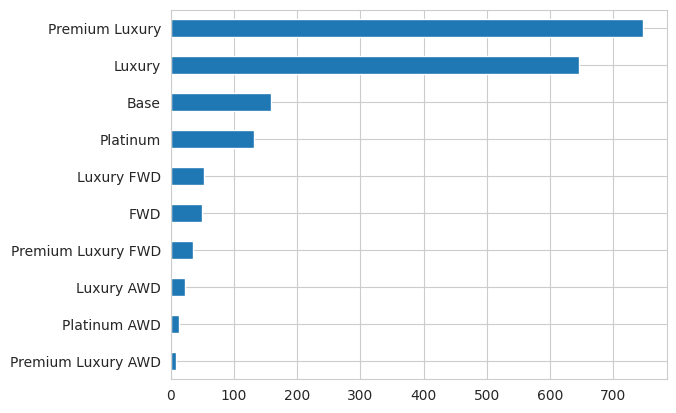

In [ ]:
cad_data['vehicle_trim'].value_counts().sort_values().plot.barh();

In [ ]:
cad_data.loc[cad_data['vehicle_trim'].str.lower().str.contains('premium') == True , 'vehicle_trim'] = 'premium'
cad_data.loc[cad_data['vehicle_trim'].str.lower().str.contains('luxury') == True , 'vehicle_trim'] = 'luxury'
cad_data.loc[cad_data['vehicle_trim'].str.lower().str.contains('base') == True , 'vehicle_trim'] = 'base'
cad_data.loc[cad_data['vehicle_trim'].str.lower().str.contains('platinum') == True , 'vehicle_trim'] = 'platinum'

In [ ]:
cad_data['vehicle_trim'].value_counts()

premium     791
luxury      720
base        159
platinum    144
FWD          49
Name: vehicle_trim, dtype: int64

In [ ]:
cad_data = cad_data[cad_data['vehicle_trim'] != 'FWD']
cad_data['vehicle_trim'].value_counts()

premium     791
luxury      720
base        159
platinum    144
Name: vehicle_trim, dtype: int64

In [ ]:
jeep_data.loc[jeep_data['vehicle_trim'].str.lower().str.contains('limited') == True , 'vehicle_trim'] = 'limited'
jeep_data.loc[jeep_data['vehicle_trim'].str.lower().str.contains('laredo') == True , 'vehicle_trim'] = 'laredo'
jeep_data.loc[jeep_data['vehicle_trim'].str.lower().str.contains('srt') == True , 'vehicle_trim'] = 'srt'

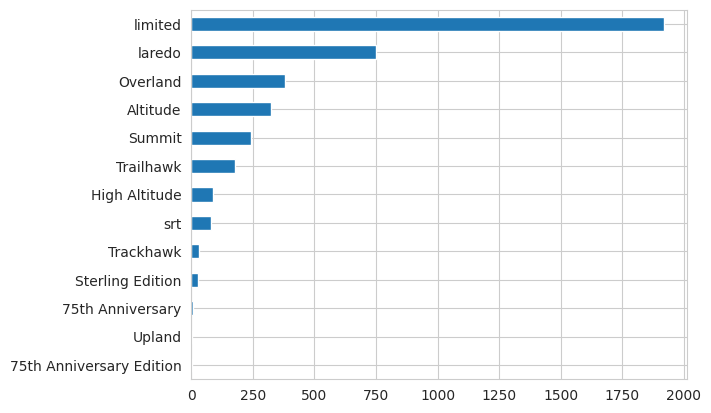

In [ ]:
jeep_data['vehicle_trim'].value_counts().sort_values().plot.barh();

In [ ]:
keep_trims = ['limited' , 'laredo' , 'overland' , 'altitude' , 'summit' , 'trailhawk' , 'high altitude' , 'srt' , 'trackhawk']
jeep_data = jeep_data.loc[jeep_data['vehicle_trim'].str.lower().isin(keep_trims) , : ]
jeep_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3992 entries, 3287 to 8620012
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sellercity            3992 non-null   object 
 1   sellerispriv          3992 non-null   bool   
 2   sellerlistsrc         3990 non-null   object 
 3   sellername            3992 non-null   object 
 4   sellerrating          3992 non-null   float64
 5   sellerrevcnt          3992 non-null   int64  
 6   sellerstate           3992 non-null   object 
 7   sellerzip             3990 non-null   float64
 8   vehbodystyle          3992 non-null   object 
 9   vehcertified          3992 non-null   bool   
 10  vehcolorext           3966 non-null   object 
 11  vehcolorint           3697 non-null   object 
 12  vehdrivetrain         3933 non-null   object 
 13  vehengine             3969 non-null   object 
 14  vehfeats              3976 non-null   object 
 15  vehfuel        

In [ ]:
jeep_data['vehicle_trim'].value_counts()

limited          1920
laredo            751
Overland          381
Altitude          325
Summit            242
Trailhawk         178
High Altitude      86
srt                79
Trackhawk          30
Name: vehicle_trim, dtype: int64

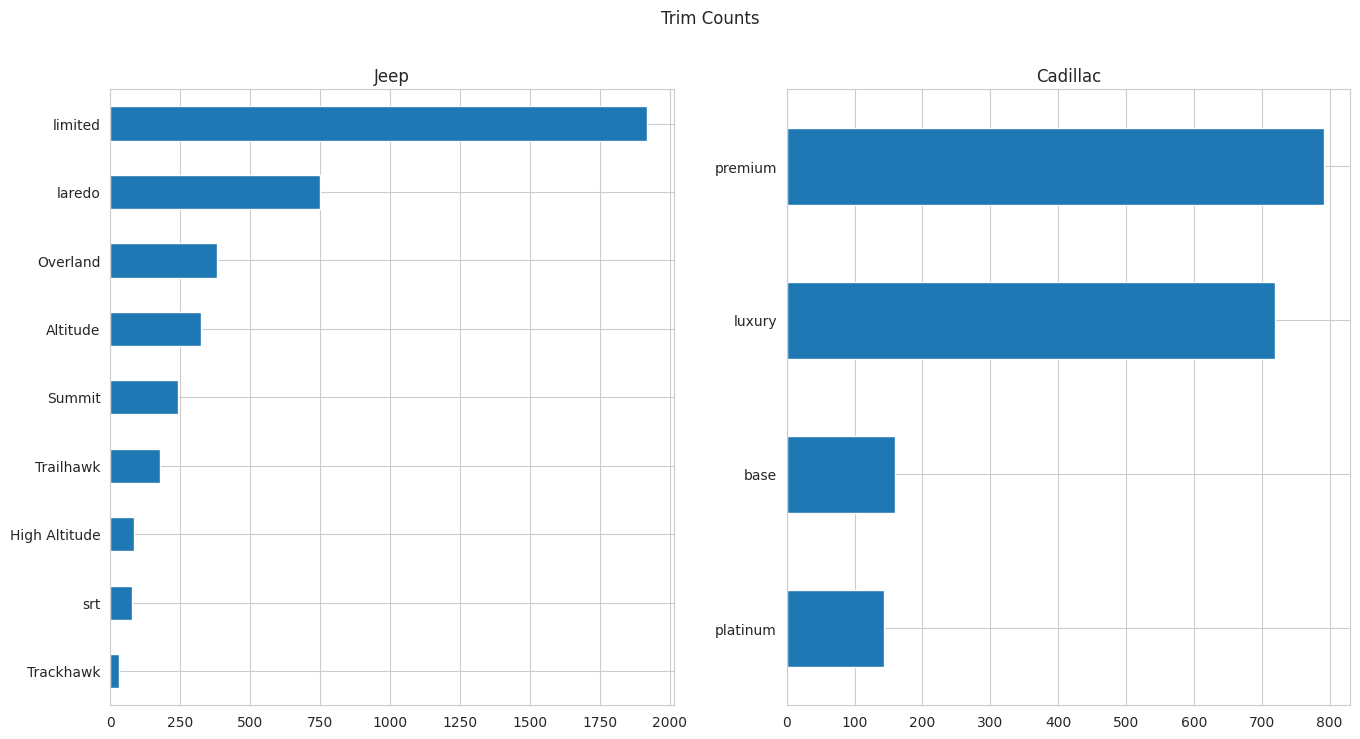

In [ ]:
fig,axes = plt.subplots(ncols = 2 , figsize =(16,8))
jeep_data['vehicle_trim'].value_counts().sort_values().plot.barh(ax = axes[0])
axes[0].set_title('Jeep')
cad_data['vehicle_trim'].value_counts().sort_values().plot.barh(ax = axes[1])
axes[1].set_title('Cadillac')
fig.suptitle('Trim Counts')
fig.savefig('trim_counts.png')


In [ ]:
y['dealer_listing_price'].isna().sum()

52

Text(0.5, 1.0, 'Distribution of Listing Price')

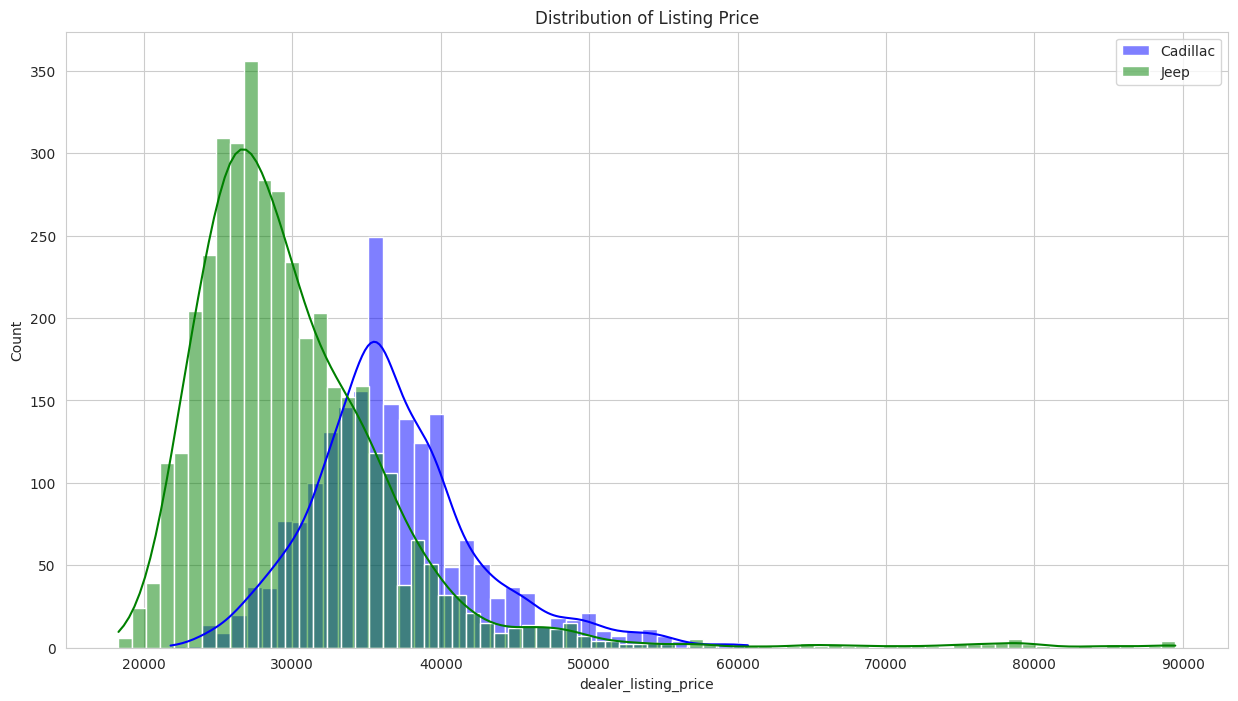

In [ ]:
fig,ax = plt.subplots(figsize = (15,8))
sns.histplot(cad_data['dealer_listing_price'] , kde = True , color = 'blue' , ax = ax , label = 'Cadillac')
sns.histplot(jeep_data['dealer_listing_price'] , kde = True , color = 'green' , ax = ax , label = 'Jeep')
ax.legend()
ax.set_title('Distribution of Listing Price')

Text(0.5, 1.0, 'Log Distribution of Listing Price')

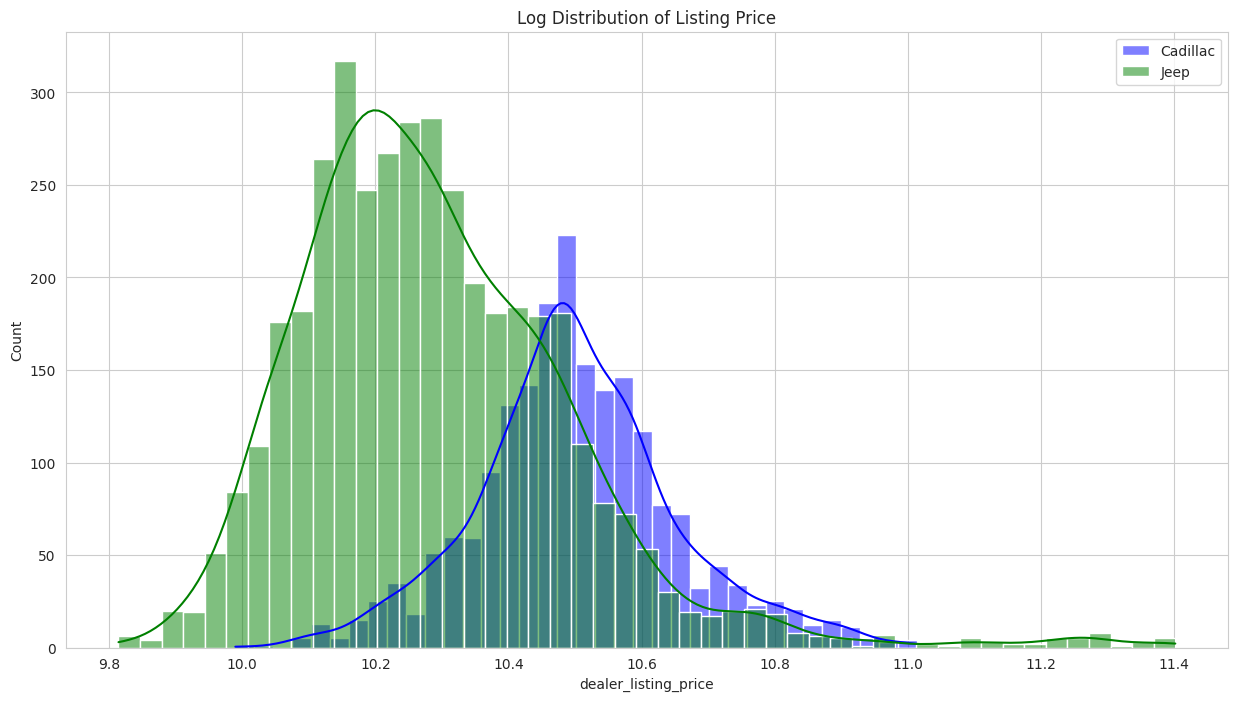

In [ ]:
fig,ax = plt.subplots(figsize = (15,8))
sns.histplot(np.log(cad_data['dealer_listing_price']) , kde = True , color = 'blue' , ax = ax , label = 'Cadillac')
sns.histplot(np.log(jeep_data['dealer_listing_price']) , kde = True , color = 'green' , ax = ax , label = 'Jeep')
ax.legend()
ax.set_title('Log Distribution of Listing Price')

Text(0.5, 0.98, 'Cadillac')

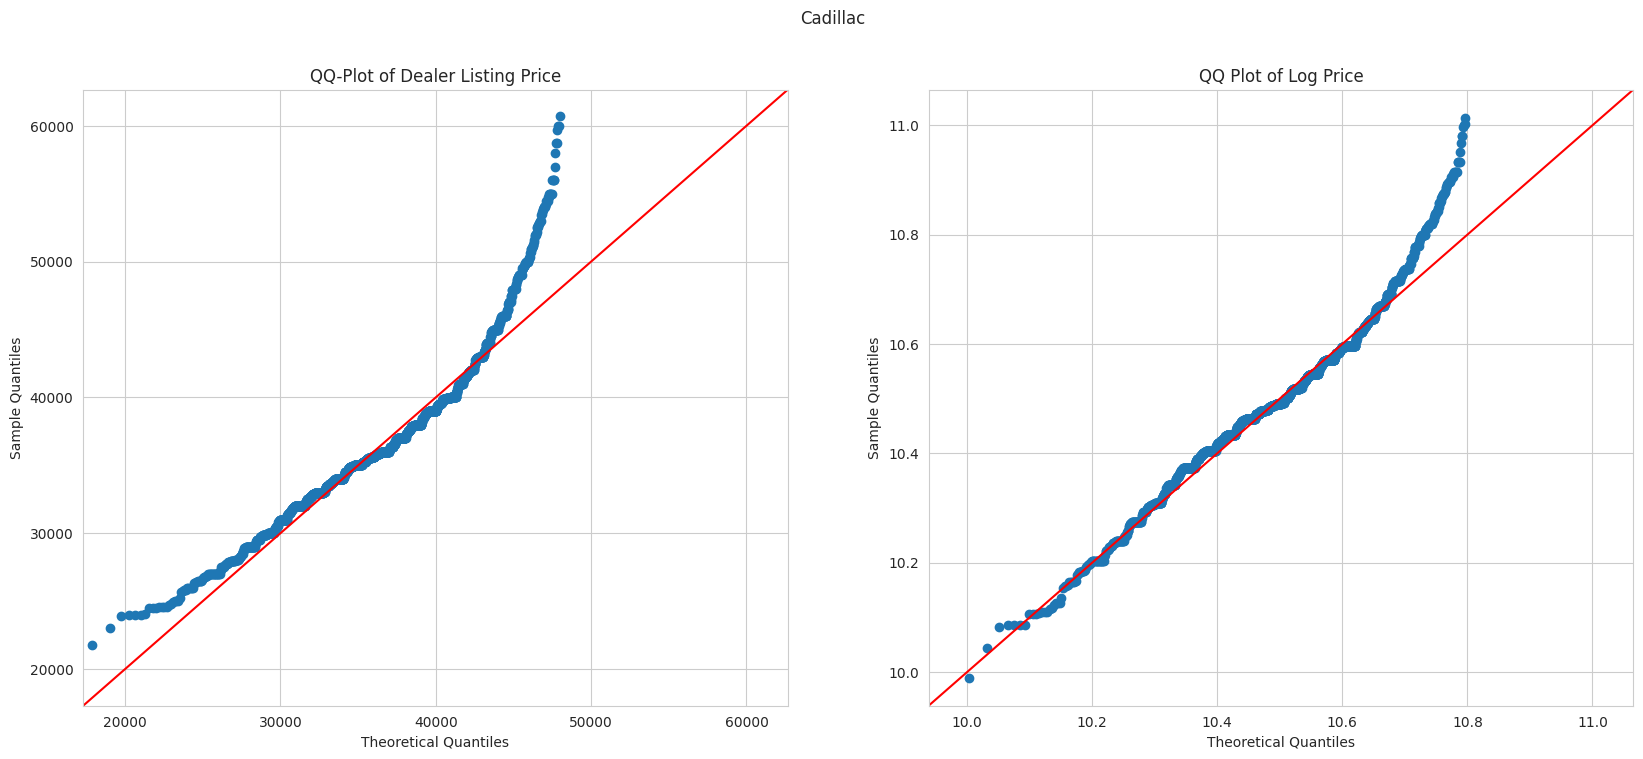

In [ ]:
fig,axes = plt.subplots(ncols = 2 , figsize = (20,8))
sm.qqplot(cad_data['dealer_listing_price'], loc = cad_data['dealer_listing_price'].mean() ,
          scale = cad_data['dealer_listing_price'].std() , ax = axes[0] , line = '45')
axes[0].set_title('QQ-Plot of Dealer Listing Price')

temp = np.log(cad_data['dealer_listing_price'])
sm.qqplot(temp , loc = temp.mean() , scale = temp.std() , ax = axes[1] , line = '45')
axes[1].set_title('QQ Plot of Log Price')
fig.suptitle('Cadillac')

Text(0.5, 0.98, 'Jeep')

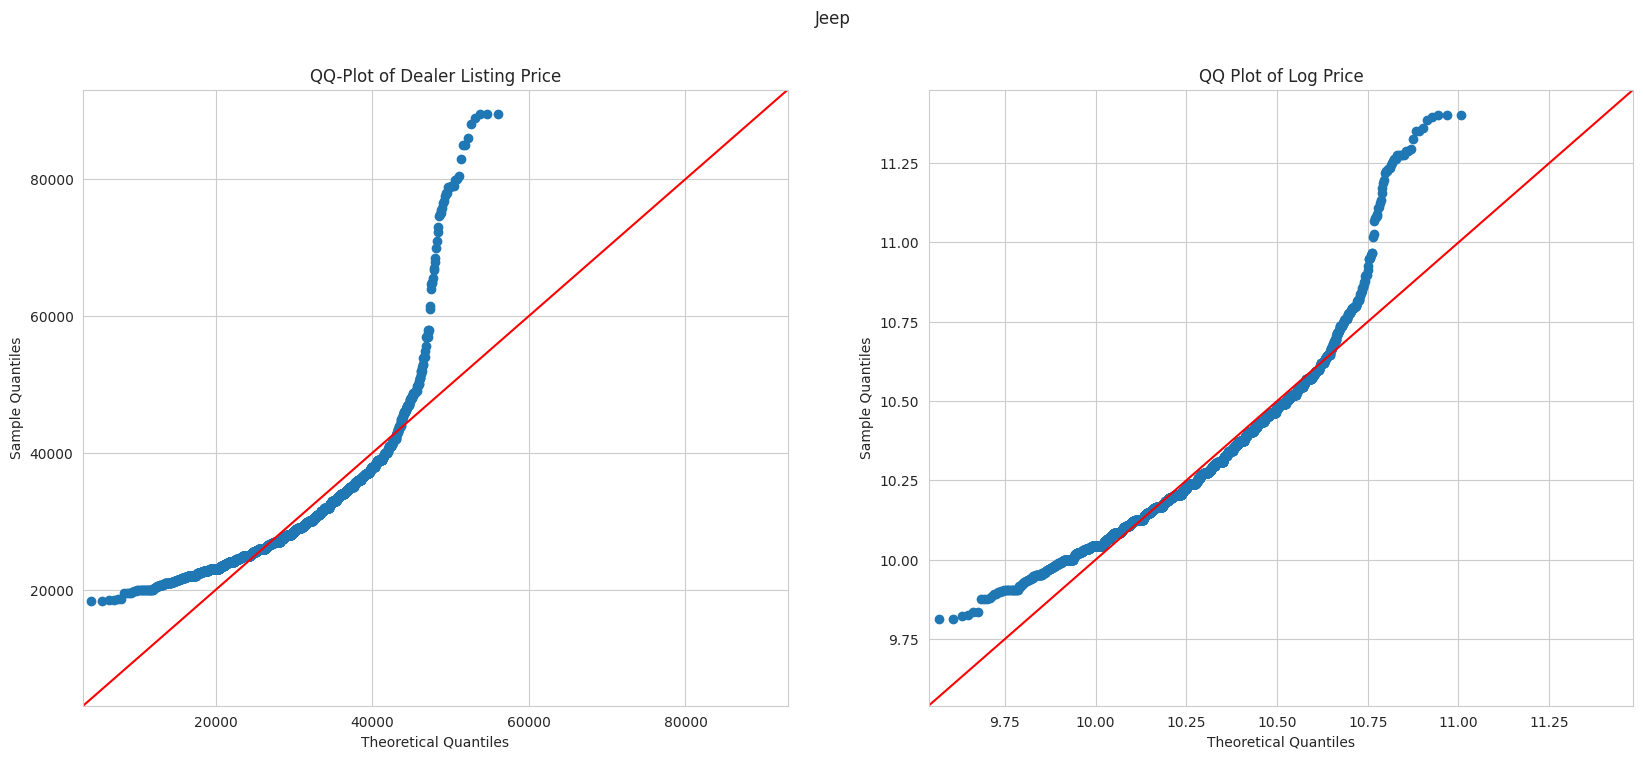

In [ ]:
fig,axes = plt.subplots(ncols = 2 , figsize = (20,8))
sm.qqplot(jeep_data['dealer_listing_price'], loc = jeep_data['dealer_listing_price'].mean() ,
          scale = jeep_data['dealer_listing_price'].std() , ax = axes[0] , line = '45')
axes[0].set_title('QQ-Plot of Dealer Listing Price')

temp = np.log(jeep_data['dealer_listing_price'])
sm.qqplot(temp , loc = temp.mean() , scale = temp.std() , ax = axes[1] , line = '45')
axes[1].set_title('QQ Plot of Log Price')
fig.suptitle('Jeep')

In [ ]:
def quick_scale(series):
  return series.sub(np.mean(series)).div(np.std(series))

Text(0.5, 1.0, 'Distribution of Scaled Log Price')

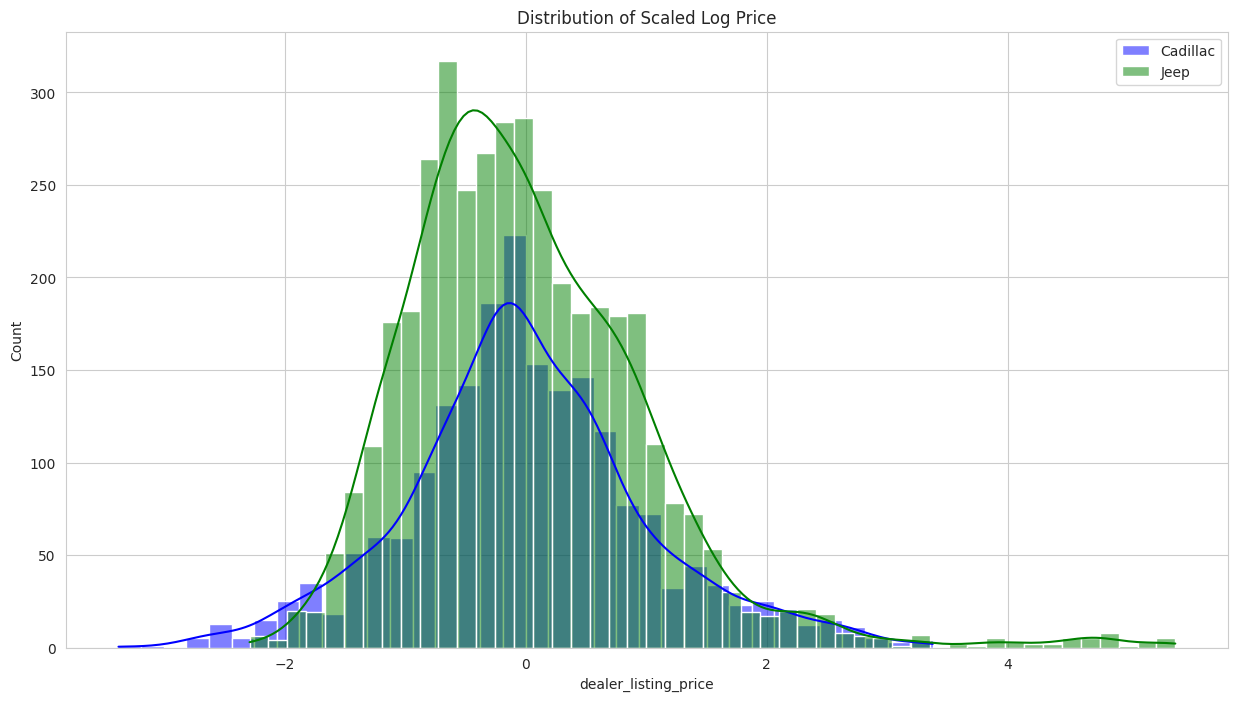

In [ ]:
fig,ax = plt.subplots(figsize = (15,8))
sns.histplot(quick_scale(np.log(cad_data['dealer_listing_price'])) , kde = True , color = 'blue' , ax = ax , label = 'Cadillac')
sns.histplot(quick_scale(np.log(jeep_data['dealer_listing_price'])) , kde = True , color = 'green' , ax = ax , label = 'Jeep')
ax.legend()
ax.set_title('Distribution of Scaled Log Price')

Text(0.5, 1.0, 'QQ-Plot of Scaled Log Price(Jeep)')

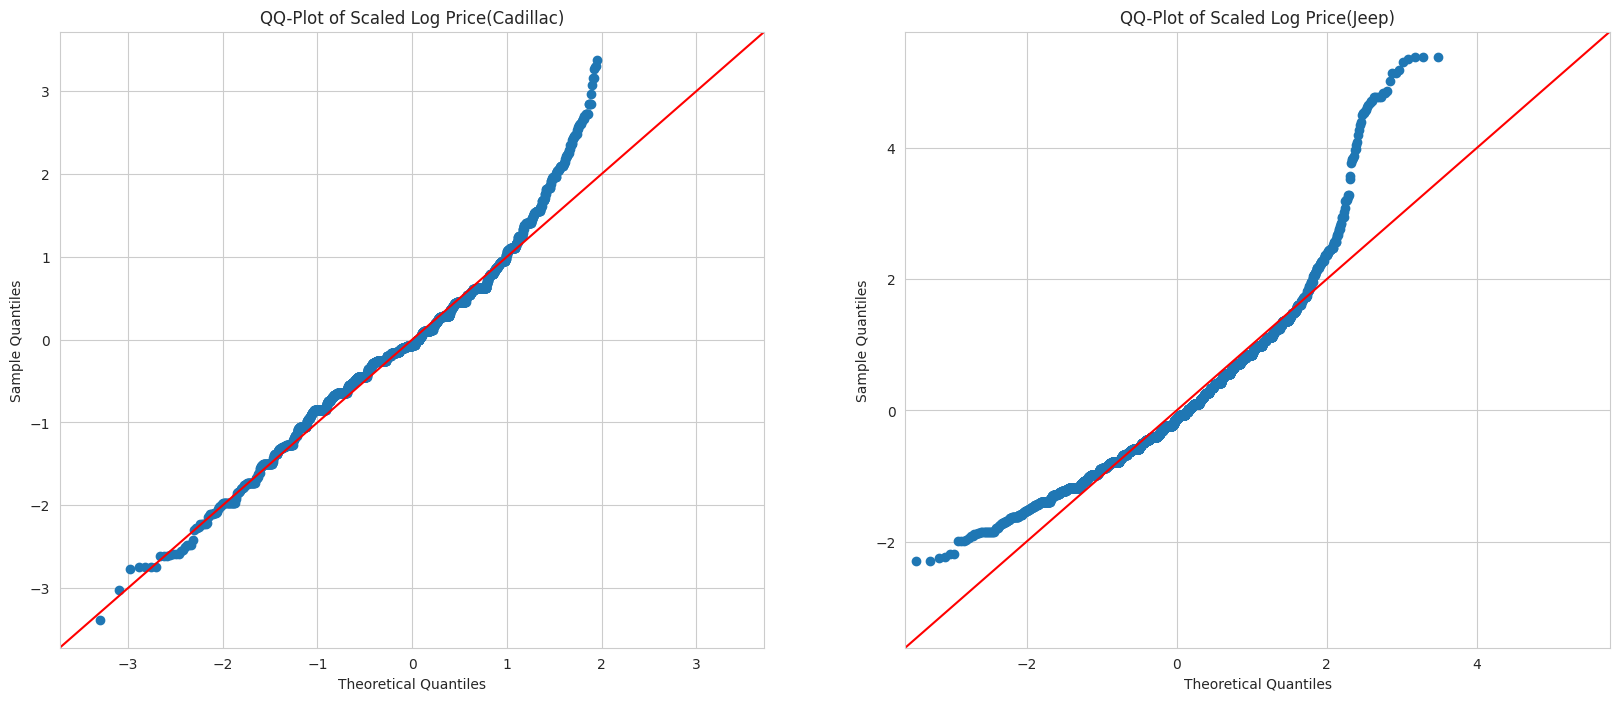

In [ ]:
fig,axes = plt.subplots(ncols = 2 , figsize = (20,8))
temp = quick_scale(np.log(cad_data['dealer_listing_price']))
sm.qqplot(temp, ax = axes[0] , line = '45')
axes[0].set_title('QQ-Plot of Scaled Log Price(Cadillac)')

temp = quick_scale(np.log(jeep_data['dealer_listing_price']))
sm.qqplot(temp, ax = axes[1] , line = '45')
axes[1].set_title('QQ-Plot of Scaled Log Price(Jeep)')

In [ ]:
cad_data.loc[: , 'log_price'] = np.log(cad_data.loc[: , 'dealer_listing_price'])
jeep_data.loc[: , 'log_price'] = np.log(jeep_data.loc[: , 'dealer_listing_price'])

In [ ]:
whole_data = pd.concat([jeep_data , cad_data])
whole_data.dropna(inplace = True)
whole_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4965 entries, 4777 to 8617378
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sellercity            4965 non-null   object 
 1   sellerispriv          4965 non-null   bool   
 2   sellerlistsrc         4965 non-null   object 
 3   sellername            4965 non-null   object 
 4   sellerrating          4965 non-null   float64
 5   sellerrevcnt          4965 non-null   int64  
 6   sellerstate           4965 non-null   object 
 7   sellerzip             4965 non-null   float64
 8   vehbodystyle          4965 non-null   object 
 9   vehcertified          4965 non-null   bool   
 10  vehcolorext           4965 non-null   object 
 11  vehcolorint           4965 non-null   object 
 12  vehdrivetrain         4965 non-null   object 
 13  vehengine             4965 non-null   object 
 14  vehfeats              4965 non-null   object 
 15  vehfuel        

In [ ]:
test_index = np.random.choice(whole_data.index,
                              size = whole_data.index.size // 5 ,
                              replace = False)
train_index = whole_data.index[[i not in test_index for i in whole_data.index]]
whole_data , test_data = whole_data.loc[train_index, :].copy() , whole_data.loc[test_index, :].copy()

In [ ]:
categorical_features = []
numeric_features = []
drop_features = []
data_cols = whole_data.columns[:26]
data_cols

Index(['sellercity', 'sellerispriv', 'sellerlistsrc', 'sellername',
       'sellerrating', 'sellerrevcnt', 'sellerstate', 'sellerzip',
       'vehbodystyle', 'vehcertified', 'vehcolorext', 'vehcolorint',
       'vehdrivetrain', 'vehengine', 'vehfeats', 'vehfuel', 'vehhistory',
       'vehlistdays', 'vehmake', 'vehmileage', 'vehmodel', 'vehpricelabel',
       'vehsellernotes', 'vehtype', 'vehtransmission', 'vehyear'],
      dtype='object')

In [ ]:
i = 0
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777       Waukesha
10882         Olean
12013        Ottawa
13173    Louisville
17626        Laurel
Name: sellercity, dtype: object

In [ ]:
(temp.value_counts() / temp.size).head(10)

Chicago            0.019386
Battle Creek       0.017875
Louisville         0.010070
Columbus           0.010070
Atlanta            0.008560
Dallas             0.008056
Raleigh            0.007805
White Bear Lake    0.007301
Cincinnati         0.007301
Palmyra            0.007301
Name: sellercity, dtype: float64

In [ ]:
drop_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head() , temp.value_counts()

(ListingID
 4777     False
 10882    False
 12013    False
 13173    False
 17626    False
 Name: sellerispriv, dtype: bool,
 False    3972
 Name: sellerispriv, dtype: int64)

In [ ]:
drop_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777       Jeep Certified Program
10882    Digital Motorworks (DMi)
12013    Digital Motorworks (DMi)
13173    Digital Motorworks (DMi)
17626    Inventory Command Center
Name: sellerlistsrc, dtype: object

In [ ]:
temp.value_counts()/temp.size

Digital Motorworks (DMi)    0.525428
Inventory Command Center    0.195871
HomeNet Automotive          0.179255
Jeep Certified Program      0.095670
My Dealer Center            0.003776
Name: sellerlistsrc, dtype: float64

In [ ]:
temp = bin_sellerlistsrc(temp)
temp.value_counts()/temp.size

dmi          0.525428
icc          0.195871
homenet      0.179255
certified    0.095670
other        0.003776
Name: sellerlistsrc, dtype: float64

In [ ]:
categorical_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     Wilde Chrysler Jeep Dodge Ram &amp; Subaru
10882        Paul Brown Chrysler Dodge Jeep RAM Kia
12013                             Sierra Motor Mall
13173                      Cross Chrysler Jeep Fiat
17626                  Carbiz Greater Washington DC
Name: sellername, dtype: object

In [ ]:
temp.value_counts()/temp.size

Vroom (Online Dealer - Nationwide Delivery)                  0.059416
Carvana                                                      0.046576
Henkel Chrysler Dodge Jeep Ram                               0.017372
F.C. Kerbeck &amp; Sons                                      0.006798
Sewell Cadillac of Dallas                                    0.006798
                                                               ...   
Neil Huffman Honda of Frankfort                              0.000252
Biggers Mitsubishi                                           0.000252
Crowe Auto Group                                             0.000252
Mark Porter Ford                                             0.000252
Easterns Automotive Group of Sterling / Direct Car Buying    0.000252
Name: sellername, Length: 1706, dtype: float64

In [ ]:
drop_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     4.8
10882    3.0
12013    3.5
13173    4.8
17626    4.7
Name: sellerrating, dtype: float64

<Axes: xlabel='sellerrating', ylabel='Count'>

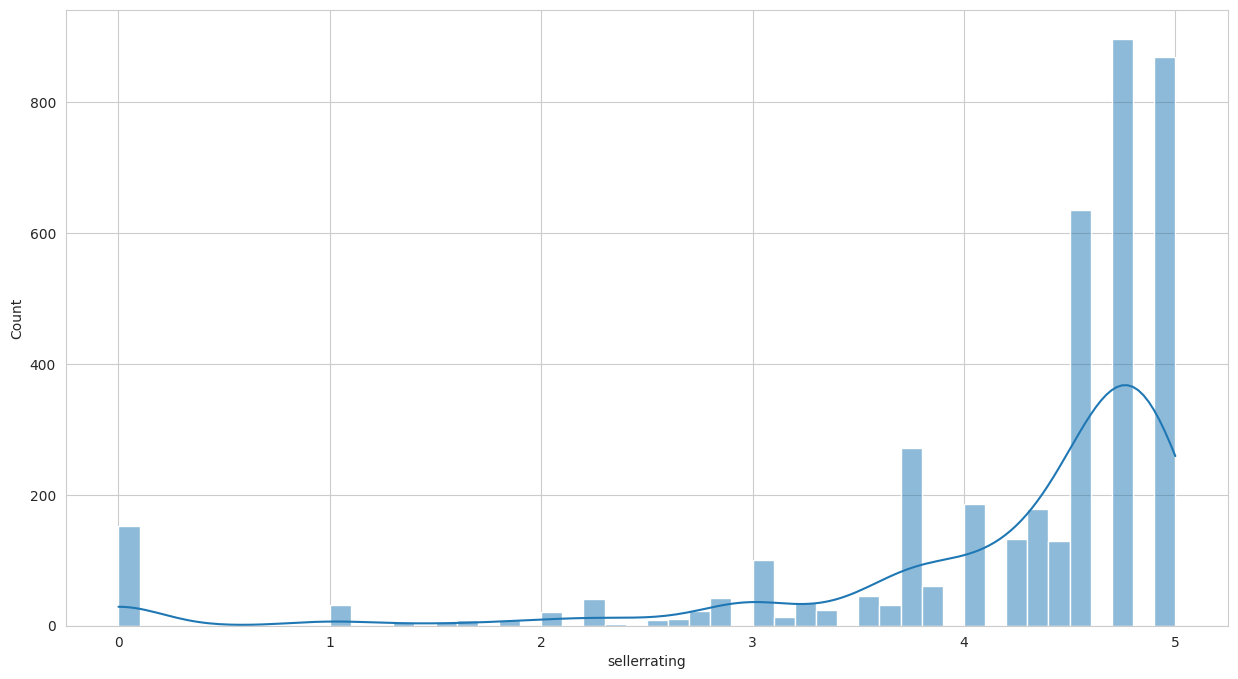

In [ ]:
fig,ax = plt.subplots(figsize = (15,8))
sns.histplot(temp, kde = True , ax = ax)

In [ ]:
categorical_features.append(data_cols[i] + '_round')
numeric_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     1405
10882      51
12013      17
13173     774
17626      69
Name: sellerrevcnt, dtype: int64

Text(0.5, 1.0, 'Log Distribution')

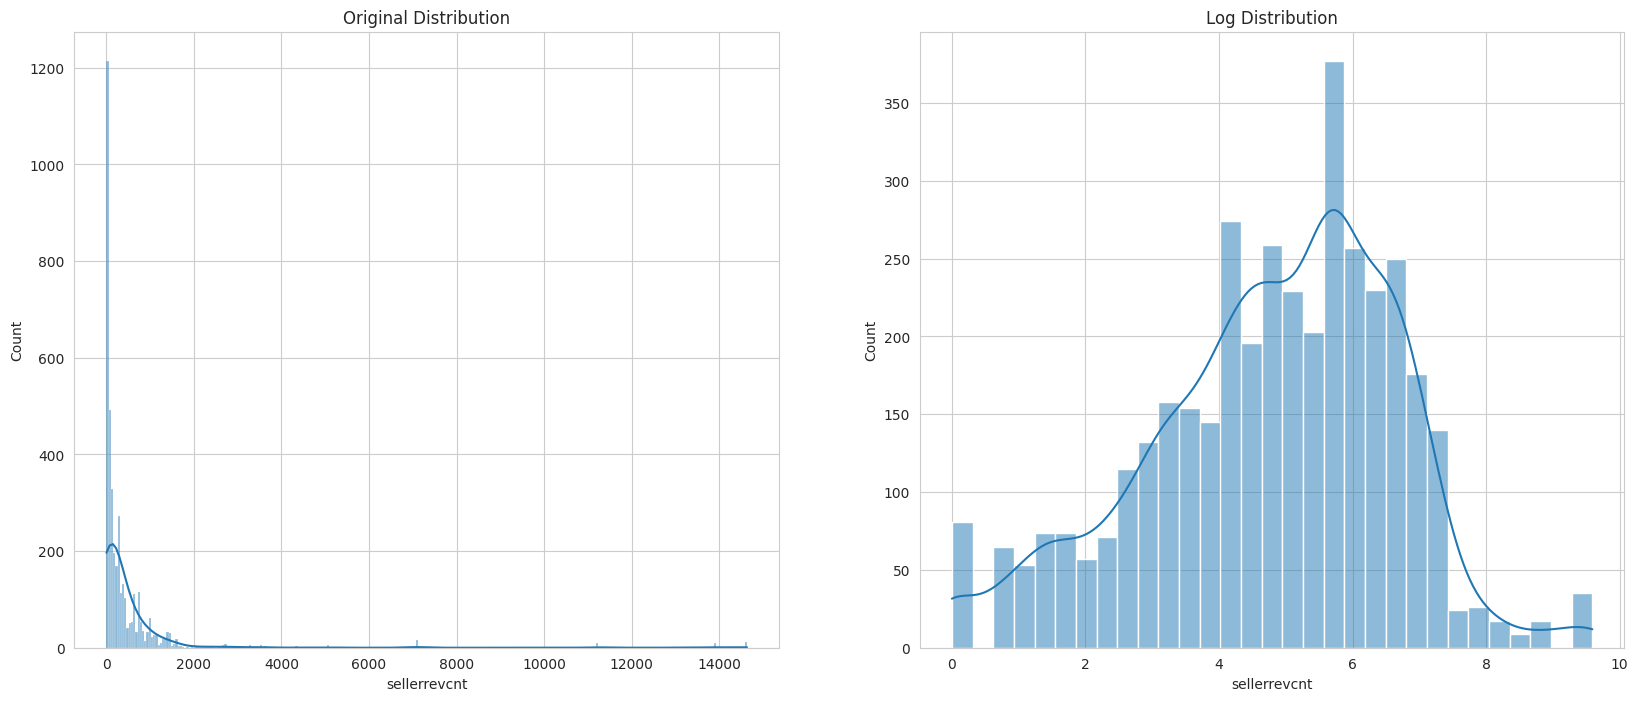

In [ ]:
fig,axes = plt.subplots(ncols = 2 , figsize =(20,8))
sns.histplot(temp , kde = True , ax = axes[0])
axes[0].set_title('Original Distribution')

sns.histplot(np.log(temp) , kde = True , ax = axes[1])
axes[1].set_title('Log Distribution')

In [ ]:
numeric_features.append(data_cols[i] + '_log')
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     WI
10882    NY
12013    IL
13173    KY
17626    MD
Name: sellerstate, dtype: object

In [ ]:
temp.value_counts().head(5).append(temp.value_counts().tail(5))

IL    477
OH    379
MI    367
WI    281
PA    212
VT      2
RI      2
MT      1
ND      1
HI      1
Name: sellerstate, dtype: int64

In [ ]:
categorical_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     53186.0
10882    14760.0
12013    61350.0
13173    40218.0
17626    20723.0
Name: sellerzip, dtype: float64

In [ ]:
temp.unique().size

1385

In [ ]:
drop_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     SUV
10882    SUV
12013    SUV
13173    SUV
17626    SUV
Name: vehbodystyle, dtype: object

In [ ]:
temp.value_counts()

SUV    3972
Name: vehbodystyle, dtype: int64

In [ ]:
drop_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777      True
10882    False
12013    False
13173    False
17626    False
Name: vehcertified, dtype: bool

In [ ]:
temp.value_counts()

False    3250
True      722
Name: vehcertified, dtype: int64

In [ ]:
categorical_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     Brilliant Black Crystal Pearlcoat
10882     Billet Silver Metallic Clearcoat
12013                  True Blue Pearlcoat
13173               Bright White Clearcoat
17626    Brilliant Black Crystal Pearlcoat
Name: vehcolorext, dtype: object

In [ ]:
temp = bin_vehcolorext(temp)
temp.value_counts()

metallic    1429
other       1375
pearl        725
clear        443
Name: vehcolorext, dtype: int64

In [ ]:
categorical_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     Black
10882    Black
12013    Black
13173    Black
17626    Black
Name: vehcolorint, dtype: object

In [ ]:
temp.value_counts()

Black                               2173
Jet Black                            581
Shara Beige                          180
Sahara Beige                         118
Cirrus                               113
                                    ... 
Beige Cloth                            1
Black/Lt. Frost Beige                  1
Black, cloth                           1
TAN                                    1
Sahara Beige W/ Jet Black Accent       1
Name: vehcolorint, Length: 89, dtype: int64

In [ ]:
temp = bin_vehcolorint(temp)
temp.value_counts()

black     3142
beige      338
cirrus     118
frost      114
brown       58
maple       57
other       51
tan         44
red         38
plum        12
Name: vehcolorint, dtype: int64

In [ ]:
categorical_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     4x4/4WD
10882        4WD
12013        4WD
13173        4WD
17626        4WD
Name: vehdrivetrain, dtype: object

In [ ]:
temp = bin_vehdrivetrain(temp)
temp.value_counts()

4wd    2713
fwd     735
awd     524
Name: vehdrivetrain, dtype: int64

In [ ]:
categorical_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     Regular Unleaded V-6 3.6 L/220
10882             3.6L V6 24V MPFI DOHC
12013             3.6L V6 24V MPFI DOHC
13173             3.6L V6 24V MPFI DOHC
17626           V6 Cylinder Engine 3.0L
Name: vehengine, dtype: object

In [ ]:
temp = bin_vehengine(temp)
temp.value_counts()

3.6      3611
5.7       153
other     108
6.4        54
6.2        29
3.0        14
8           3
Name: vehengine, dtype: int64

In [ ]:
categorical_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     ['18 WHEEL &amp; 8.4 RADIO GROUP-inc: Nav-Capa...
10882    ['1st and 2nd row curtain head airbags', '4-wh...
12013    ['1st and 2nd row curtain head airbags', '4-wh...
13173    ['1st and 2nd row curtain head airbags', '4-wh...
17626    ['A/C,8-Speed A/T,4x4,4-Wheel Disc Brakes,4-Wh...
Name: vehfeats, dtype: object

In [ ]:
temp2 = process_vehfeats(temp)

In [ ]:
temp2.head()

,brake,airbag,input,security,audio,camera,bluetooth,alloy,umin,fm,cond,seat
ListingID,,,,,,,,,,,,
4777,1,0,1,0,1,0,0,0,1,1,0,0
10882,1,1,0,1,1,0,0,0,0,0,0,1
12013,1,1,0,0,1,0,0,0,0,1,1,0
13173,1,1,0,1,1,0,0,0,0,0,0,1
17626,1,0,1,0,1,1,0,0,0,1,0,0


In [ ]:
temp2.mean()

brake        0.926737
airbag       0.595418
input        0.212487
security     0.401309
audio        0.812941
camera       0.161631
bluetooth    0.239678
alloy        0.163142
umin         0.235398
fm           0.294562
cond         0.192598
seat         0.219285
dtype: float64

In [ ]:
i += 1
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     Gasoline
10882    Gasoline
12013    Gasoline
13173    Gasoline
17626      Diesel
Name: vehfuel, dtype: object

In [ ]:
temp.value_counts()

Gasoline         3695
E85 Flex Fuel     246
Diesel             26
Unknown             5
Name: vehfuel, dtype: int64

In [ ]:
categorical_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777                  1 Owner, Buyback Protection Eligible
10882    1 Owner, Non-Personal Use Reported, Buyback Pr...
12013    1 Owner, Accident(s) Reported, Non-Personal Us...
13173    1 Owner, Non-Personal Use Reported, Buyback Pr...
17626                 1 Owner, Buyback Protection Eligible
Name: vehhistory, dtype: object

In [ ]:
temp.index

Int64Index([   4777,   10882,   12013,   13173,   17626,   17982,   20984,
              25753,   26678,   31932,
            ...
            8564111, 8564905, 8567162, 8567842, 8577448, 8584119, 8597526,
            8599564, 8601212, 8604205],
           dtype='int64', name='ListingID', length=3972)

In [ ]:
# temp2_cat , temp2_oh = process_vehhistory(temp)

In [ ]:
# temp2_cat.mean()

In [ ]:
# temp2_oh.mean()

In [ ]:
i += 1
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777      28.107014
10882     30.967500
12013    194.482338
13173      6.731481
17626     28.315313
Name: vehlistdays, dtype: float64

Text(0.5, 1.0, 'Log Distribution')

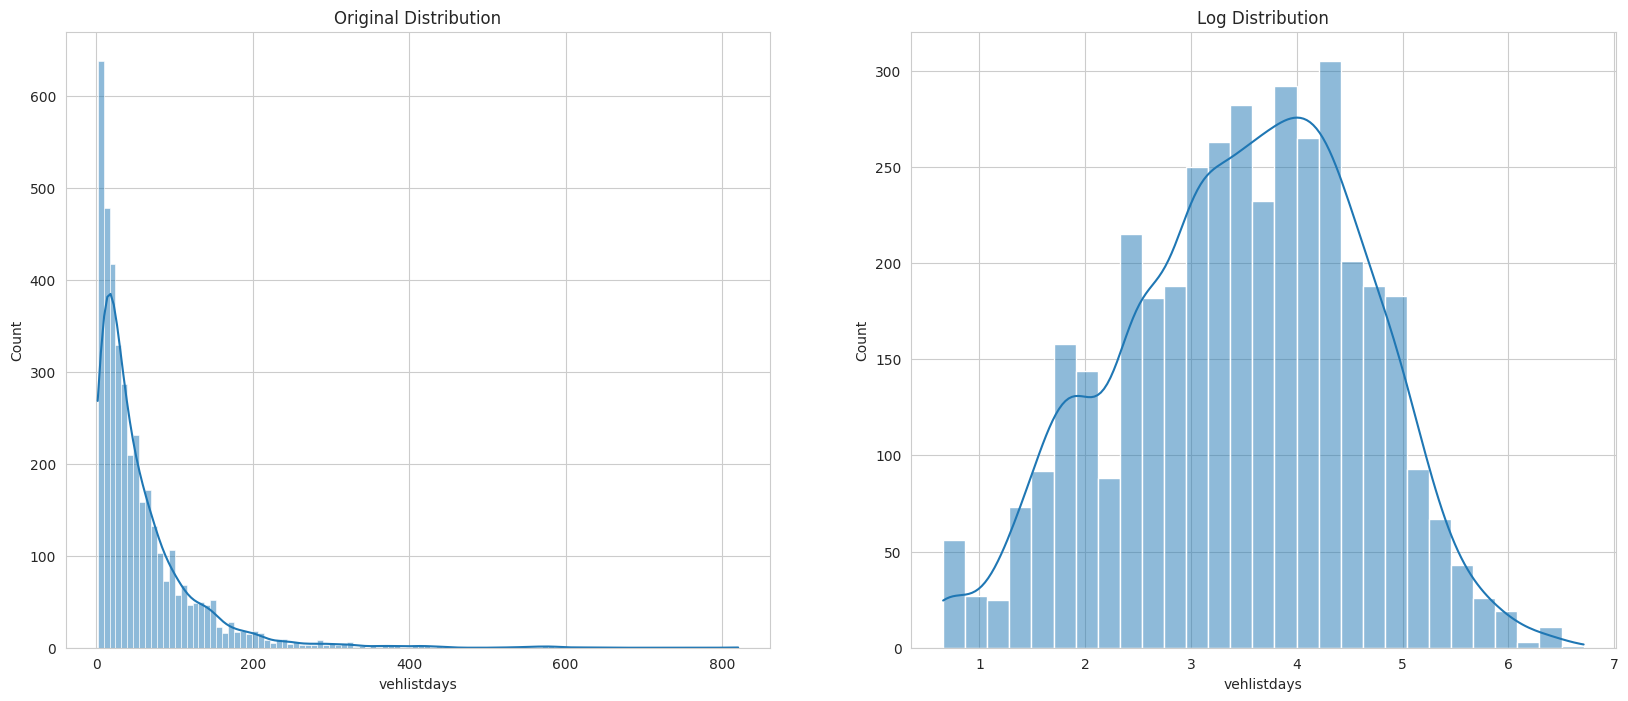

In [ ]:
fig,axes = plt.subplots(ncols = 2 , figsize =(20,8))
sns.histplot(temp , kde = True , ax = axes[0])
axes[0].set_title('Original Distribution')

sns.histplot(np.log(temp) , kde = True , ax = axes[1])
axes[1].set_title('Log Distribution')

In [ ]:
numeric_features.append(data_cols[i])
numeric_features.append(data_cols[i] + '_log')

In [ ]:
i += 1
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     Jeep
10882    Jeep
12013    Jeep
13173    Jeep
17626    Jeep
Name: vehmake, dtype: object

In [ ]:
categorical_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     38957.0
10882    34649.0
12013    48814.0
13173    17692.0
17626    32858.0
Name: vehmileage, dtype: float64

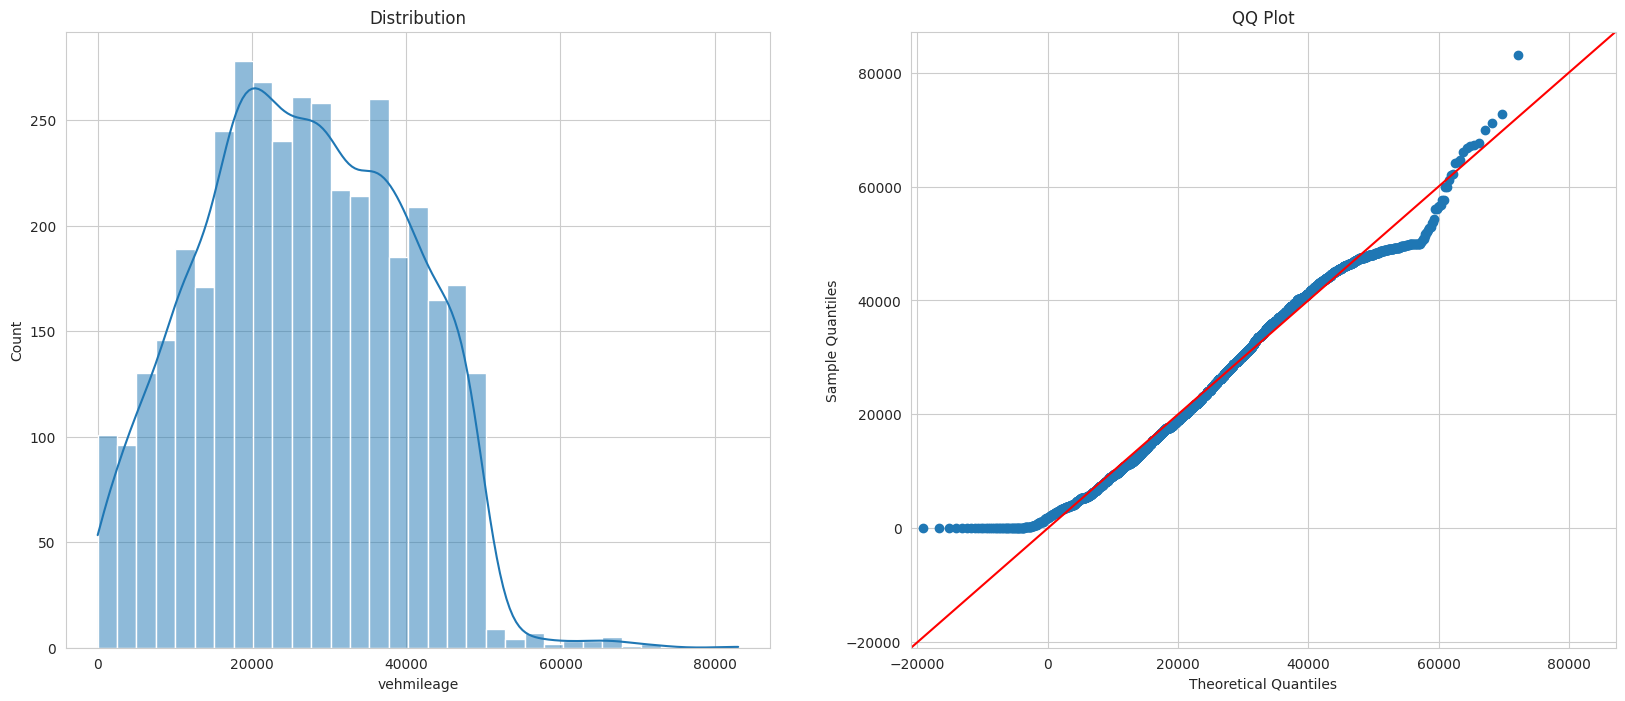

In [ ]:
fig,axes = plt.subplots(ncols = 2 , figsize = (20,8))
sns.histplot(temp , kde = True , ax = axes[0])
axes[0].set_title('Distribution')

sm.qqplot(temp , loc = temp.mean() , scale = temp.std() , ax = axes[1] , line = '45')
axes[1].set_title('QQ Plot');


In [ ]:
numeric_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     Grand Cherokee
10882    Grand Cherokee
12013    Grand Cherokee
13173    Grand Cherokee
17626    Grand Cherokee
Name: vehmodel, dtype: object

In [ ]:
temp.value_counts()

Grand Cherokee    2721
XT5               1251
Name: vehmodel, dtype: int64

In [ ]:
drop_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     Good Deal
10882    Good Deal
12013    Good Deal
13173    Good Deal
17626    Good Deal
Name: vehpricelabel, dtype: object

In [ ]:
temp.value_counts()

Good Deal     2962
Great Deal     567
Fair Price     443
Name: vehpricelabel, dtype: int64

In [ ]:
categorical_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     Backed by a rigorous 125-point inspection by f...
10882    Priced below KBB Fair Purchase Price! Clean CA...
12013    2017 Jeep Grand Cherokee Laredo True Blue Pear...
13173    Sterling Edition .. 20 inch Heritage Wheels .....
17626    &#x3D;&#x3D;&#x3D;&#x3D;&#x3D;&#x3D;: *Certifi...
Name: vehsellernotes, dtype: object

In [ ]:
temp.iloc[1]

'Priced below KBB Fair Purchase Price! Clean CARFAX. Balance of new car warranty., Air Conditioning, Alloy wheels, Heated front seats, Leather Trimmed Bucket Seats, Power driver seat, Power Liftgate, Power passenger seat, Power windows, Remote keyless entry, Speed control. Billet Silver Metallic Clearcoat 2018 Jeep Grand Cherokee Limited 4D Sport Utility 4WD 8-Speed Automatic 3.6L V6 24V VVT 48 hour exchange policy, every 5th oil change free, free NY and Pa inspections, We make your payment referral program. For a hassle free purchase experience, reach out to the Sales team at Paul Brown Motors at 716-351-3804. Conveniently located at 1145 East State Street, Olean NY 14760. We are worth the trip! Travel from over 75 miles away and dont purchase we will supply you with $25 gas card! Paul Brown Chevy, A Dealer For the People! Paul Brown A Dealer For The People!'

In [ ]:
tfidf_data = process_vehsellernotes(temp)

In [ ]:
tfidf_data

(<3972x100 sparse matrix of type '<class 'numpy.float64'>'
 	with 153204 stored elements in Compressed Sparse Row format>,
 TfidfVectorizer(max_features=100))

In [ ]:
i += 1
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     Used
10882    Used
12013    Used
13173    Used
17626    Used
Name: vehtype, dtype: object

In [ ]:
temp.value_counts()

Used    3972
Name: vehtype, dtype: int64

In [ ]:
drop_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     8-Speed Automatic w/OD
10882         8-Speed Automatic
12013         8-Speed Automatic
13173         8-Speed Automatic
17626               8-Speed A/T
Name: vehtransmission, dtype: object

In [ ]:
temp.value_counts()

8-Speed Automatic                3008
8-Speed Automatic w/OD            468
Automatic                         224
8-Speed Shiftable Automatic        54
AUTOMATIC                          53
Automatic 8-Speed                  51
8-Speed Automatic (845RE)          36
8-Speed A/T                        32
8-Speed Automatic (850RE)           8
8 Speed Automatic                   6
8-Speed                             6
Automatic, 8-Spd                    4
8-Speed Automatic (8HP70)           4
8-SPEED AUTOMATIC                   3
8-Spd TorqueFlite Automatic         3
8 speed automatic                   2
Not Specified                       2
6-Speed Automatic                   2
Automatic w/OD                      1
aujtomatic                          1
AUTO                                1
8-Spd Auto 850RE Trans (Make)       1
automatic                           1
Shiftable Automatic                 1
Name: vehtransmission, dtype: int64

In [ ]:
drop_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777     2015
10882    2018
12013    2017
13173    2018
17626    2015
Name: vehyear, dtype: int64

In [ ]:
temp.value_counts()

2018    1294
2017    1249
2015    1033
2016     306
2019      90
Name: vehyear, dtype: int64

In [ ]:
categorical_features.append(data_cols[i])
i += 1

In [ ]:
print(numeric_features)

['sellerrating', 'sellerrevcnt_log', 'vehlistdays', 'vehlistdays_log', 'vehmileage']


In [ ]:
print(categorical_features)

['sellerlistsrc', 'sellerrating_round', 'sellerstate', 'vehcertified', 'vehcolorext', 'vehcolorint', 'vehdrivetrain', 'vehengine', 'vehfuel', 'vehmake', 'vehpricelabel', 'vehyear']


In [ ]:
print(drop_features)

['sellercity', 'sellerispriv', 'sellername', 'sellerzip', 'vehbodystyle', 'vehmodel', 'vehtype', 'vehtransmission']


In [ ]:
whole_data.head()

,sellercity,sellerispriv,sellerlistsrc,sellername,sellerrating,sellerrevcnt,sellerstate,sellerzip,vehbodystyle,vehcertified,...,vehmileage,vehmodel,vehpricelabel,vehsellernotes,vehtype,vehtransmission,vehyear,vehicle_trim,dealer_listing_price,log_price
ListingID,,,,,,,,,,,,,,,,,,,,,
4777,Waukesha,False,Jeep Certified Program,Wilde Chrysler Jeep Dodge Ram &amp; Subaru,4.8,1405,WI,53186.0,SUV,True,...,38957.0,Grand Cherokee,Good Deal,Backed by a rigorous 125-point inspection by f...,Used,8-Speed Automatic w/OD,2015,laredo,23249.0,10.054017
10882,Olean,False,Digital Motorworks (DMi),Paul Brown Chrysler Dodge Jeep RAM Kia,3.0,51,NY,14760.0,SUV,False,...,34649.0,Grand Cherokee,Good Deal,Priced below KBB Fair Purchase Price! Clean CA...,Used,8-Speed Automatic,2018,limited,27900.0,10.236382
12013,Ottawa,False,Digital Motorworks (DMi),Sierra Motor Mall,3.5,17,IL,61350.0,SUV,False,...,48814.0,Grand Cherokee,Good Deal,2017 Jeep Grand Cherokee Laredo True Blue Pear...,Used,8-Speed Automatic,2017,laredo,22989.0,10.042771
13173,Louisville,False,Digital Motorworks (DMi),Cross Chrysler Jeep Fiat,4.8,774,KY,40218.0,SUV,False,...,17692.0,Grand Cherokee,Good Deal,Sterling Edition .. 20 inch Heritage Wheels .....,Used,8-Speed Automatic,2018,limited,36500.0,10.505068
17626,Laurel,False,Inventory Command Center,Carbiz Greater Washington DC,4.7,69,MD,20723.0,SUV,False,...,32858.0,Grand Cherokee,Good Deal,&#x3D;&#x3D;&#x3D;&#x3D;&#x3D;&#x3D;: *Certifi...,Used,8-Speed A/T,2015,limited,28000.0,10.239960


In [ ]:
features = whole_data.iloc[: , :-3]
target1 = whole_data['vehicle_trim']
target2 = whole_data['dealer_listing_price']
target3 = whole_data['log_price']

In [ ]:
scaler,encoder,tfidf,processed_features = preprocess_features(features)

In [ ]:
processed_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3972 entries, 4777 to 8604205
Columns: 218 entries, sellerrating to luxury
dtypes: float64(206), int64(12)
memory usage: 6.8 MB


In [ ]:
pca = PCA()
pca_features = pca.fit_transform(processed_features)

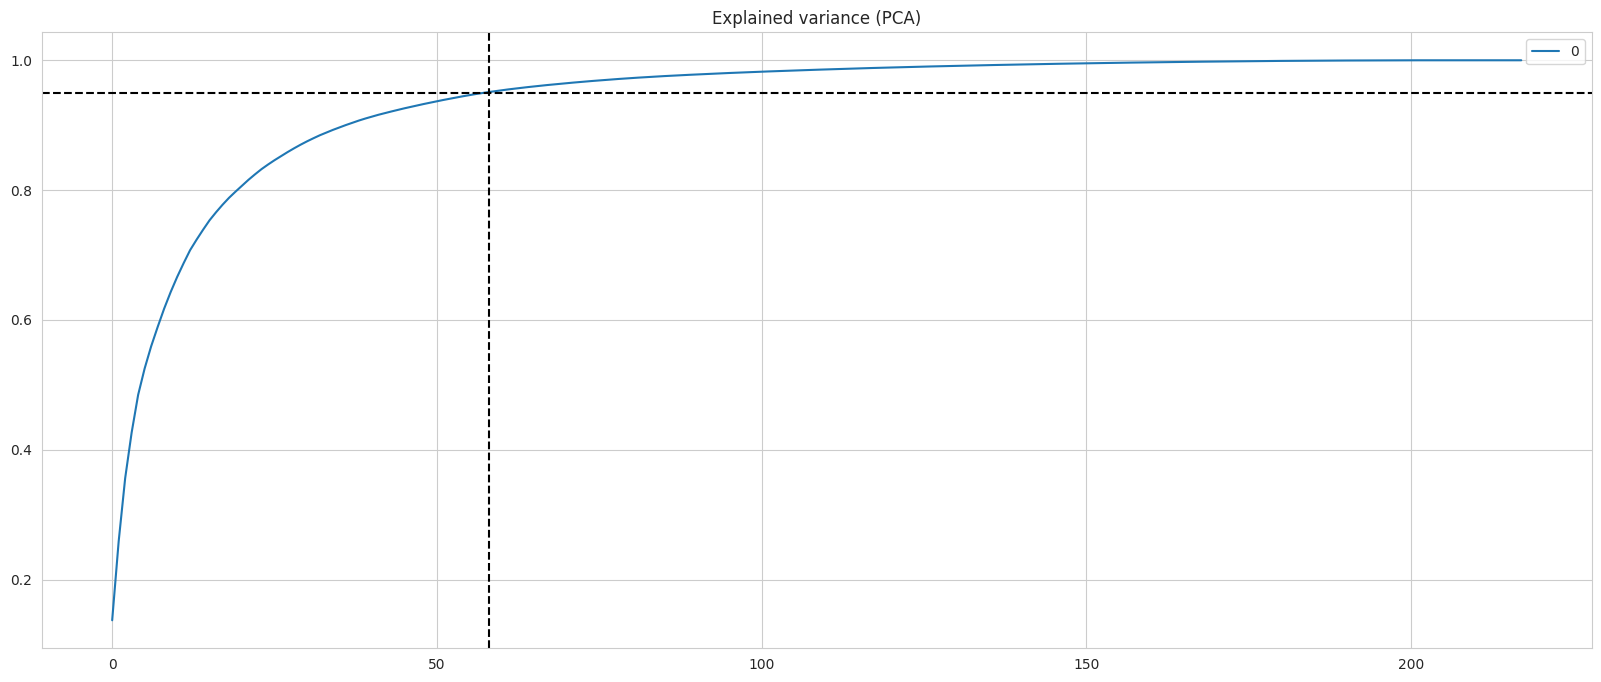

In [ ]:
explained_variance = pd.DataFrame(pca.explained_variance_ratio_)
ninetyfive_p = ((explained_variance.cumsum() > 0.95).drop_duplicates()).index[-1]

fig , ax = plt.subplots(figsize = (20,8))
explained_variance.cumsum().plot(ax = ax)
ax.set_title('Explained variance (PCA)')
ax.axvline(ninetyfive_p,linestyle = 'dashed' , c = 'black')
ax.axhline(0.95,linestyle = 'dashed' , c = 'black');

In [ ]:
tsne = TSNE()
tsne_features = tsne.fit_transform(processed_features)

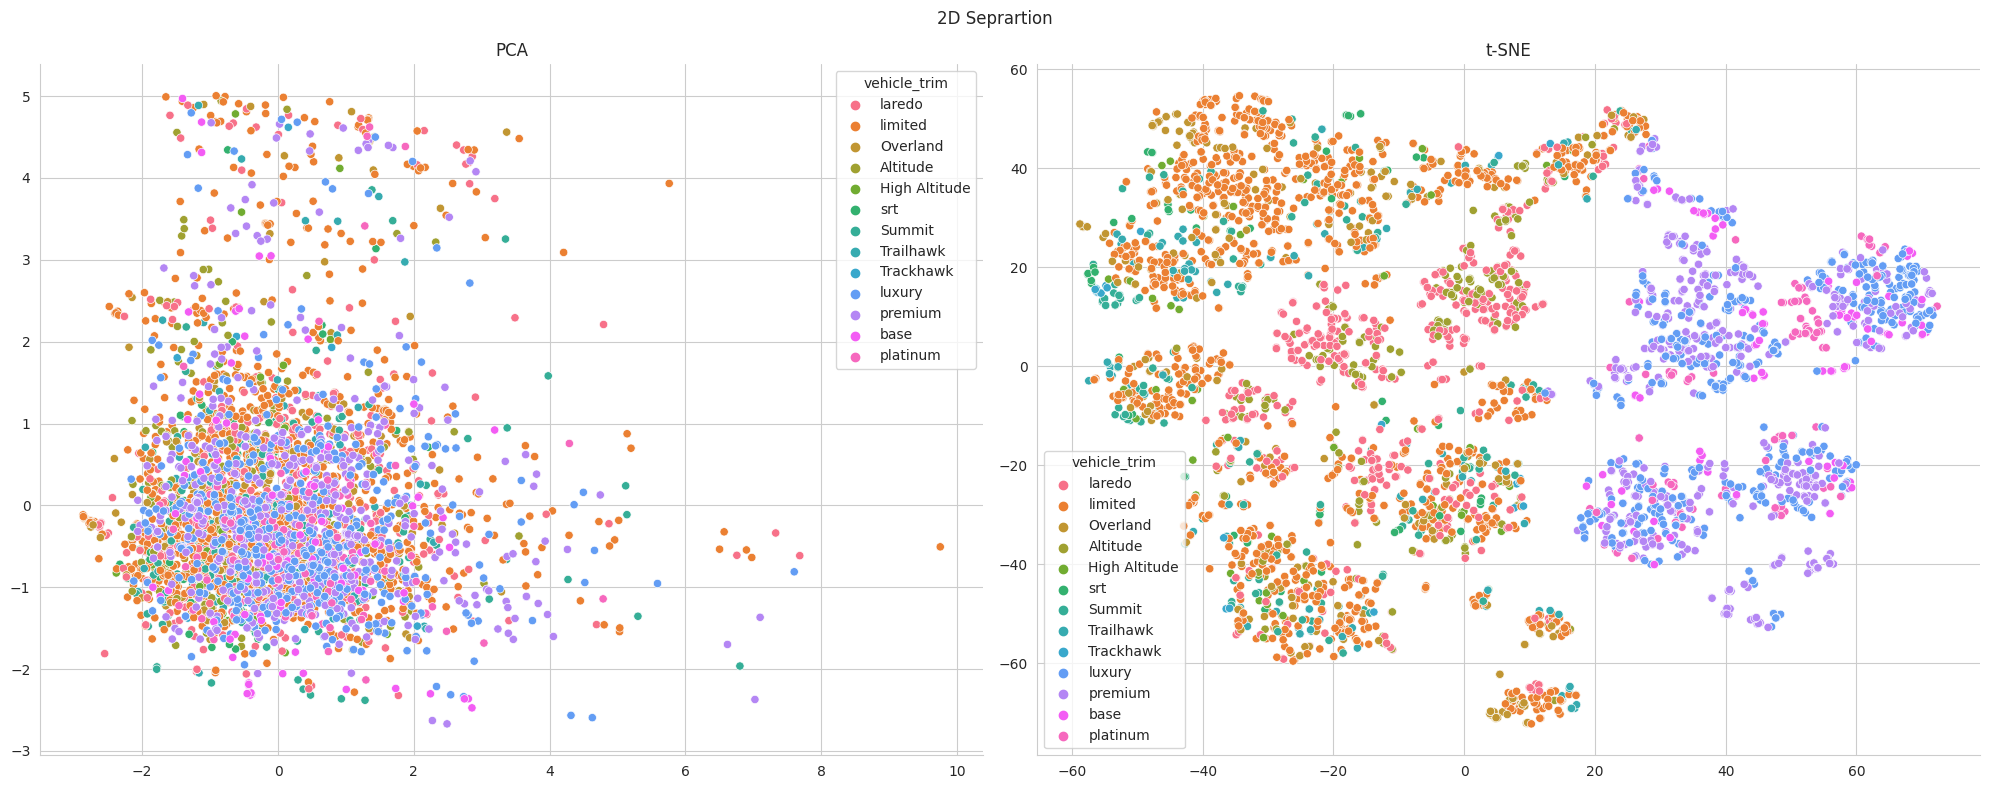

In [ ]:
fig,axes = plt.subplots(ncols = 2 , figsize = (20,8))
sns.scatterplot(x = pca_features[: , 0] , y = pca_features[: , 1] , hue = target1 , ax = axes[0])
axes[0].set_title('PCA')

sns.scatterplot(x = tsne_features[: , 0] , y = tsne_features[: , 1] , hue = target1 , ax = axes[1])
axes[1].set_title('t-SNE')

fig.suptitle('2D Seprartion')
sns.despine()
plt.tight_layout();

In [ ]:
mutual_info = mutual_info_regression(processed_features , target2)
mutual_info = pd.Series(mutual_info , index = processed_features.columns)

Text(0.5, 0.98, 'Most Important Features by Mutual Information')

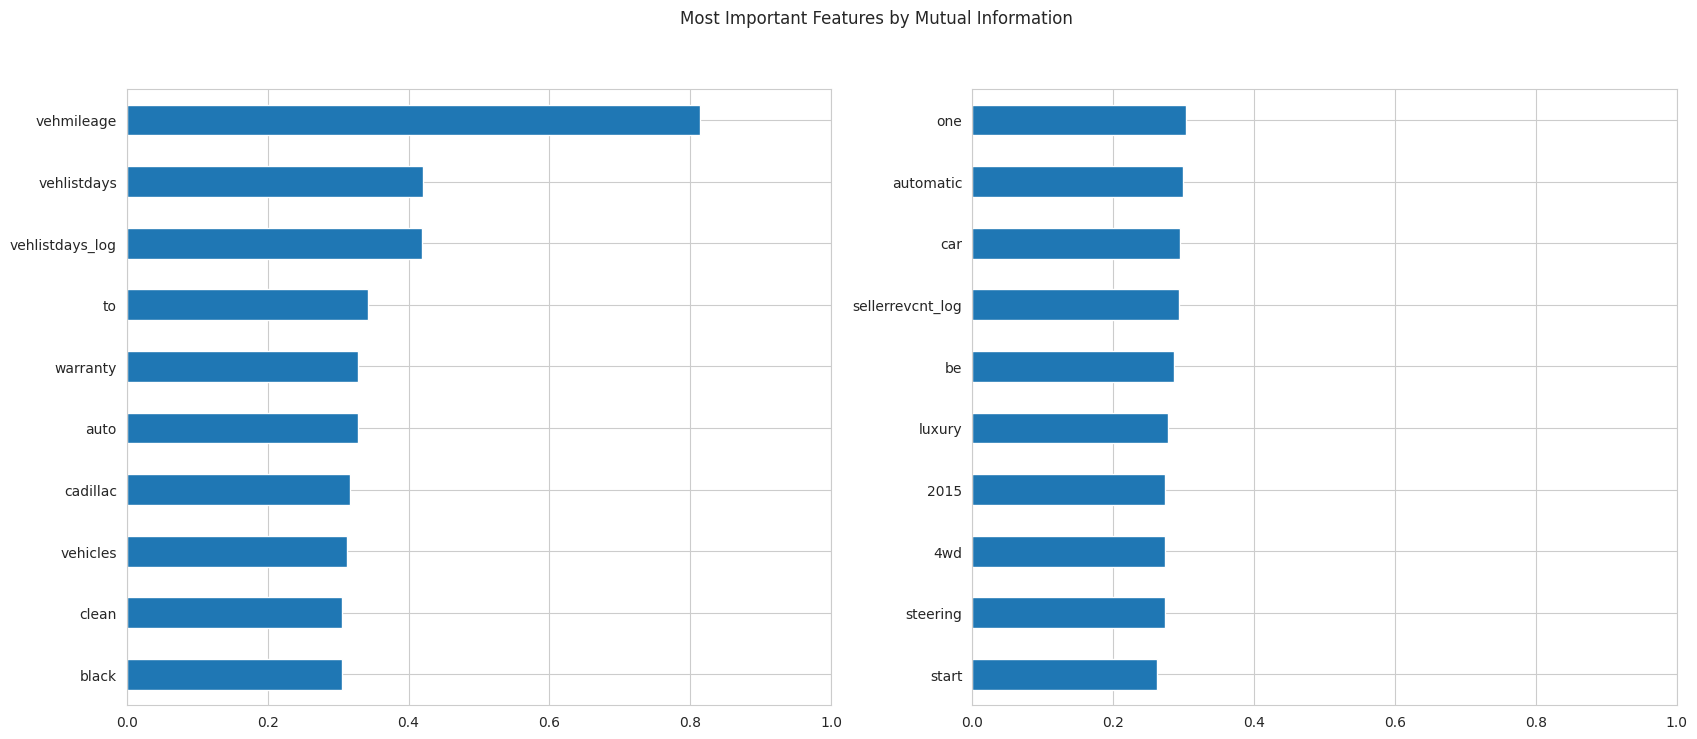

In [ ]:
fig,axes = plt.subplots(ncols = 2 , figsize = (20,8))
mutual_info.sort_values().tail(10).plot.barh(ax = axes[0])
axes[0].set_xlim(0,1)

mutual_info.sort_values()[-20:-10].plot.barh(ax = axes[1])
axes[1].set_xlim(0,1)
fig.suptitle('Most Important Features by Mutual Information')

In [ ]:
whole_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3972 entries, 4777 to 8604205
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sellercity            3972 non-null   object 
 1   sellerispriv          3972 non-null   bool   
 2   sellerlistsrc         3972 non-null   object 
 3   sellername            3972 non-null   object 
 4   sellerrating          3972 non-null   float64
 5   sellerrevcnt          3972 non-null   int64  
 6   sellerstate           3972 non-null   object 
 7   sellerzip             3972 non-null   float64
 8   vehbodystyle          3972 non-null   object 
 9   vehcertified          3972 non-null   bool   
 10  vehcolorext           3972 non-null   object 
 11  vehcolorint           3972 non-null   object 
 12  vehdrivetrain         3972 non-null   object 
 13  vehengine             3972 non-null   object 
 14  vehfeats              3972 non-null   object 
 15  vehfuel        

# Modeling Trim

In [ ]:
trim_encoder = LabelEncoder()
target1_coded = trim_encoder.fit_transform(target1.values)

In [ ]:
cv = KFold(shuffle = True , random_state = 1).split(processed_features.values , target1_coded)

roc_scores = dict()
preds = dict()
preds_proba = dict()
test_Xs = dict()
test_ys = dict()

for i , (train_index , test_index ) in enumerate(cv):
  X_train = processed_features.values[train_index]
  y_train = target1_coded[train_index]

  test_Xs[i] = processed_features.values[test_index]
  test_ys[i] = target1_coded[test_index]

  model = XGBClassifier(use_label_encoder = False , eval_metric = 'merror')
  fit_model = model.fit(X_train , y_train)

  preds[i] = fit_model.predict(test_Xs[i])
  preds_proba[i] = fit_model.predict_proba(test_Xs[i])

  roc_scores [i] = roc_auc_score(test_ys[i] , preds_proba[i] , multi_class = 'ovr')

In [ ]:
[print(f'Fold {i} , AUC Score = {score}') for i , score in enumerate(roc_scores.values())];

Fold 0 , AUC Score = 0.9818206749388791
Fold 1 , AUC Score = 0.9796126393362196
Fold 2 , AUC Score = 0.9797179334996057
Fold 3 , AUC Score = 0.9842578411151472
Fold 4 , AUC Score = 0.9829257686122879


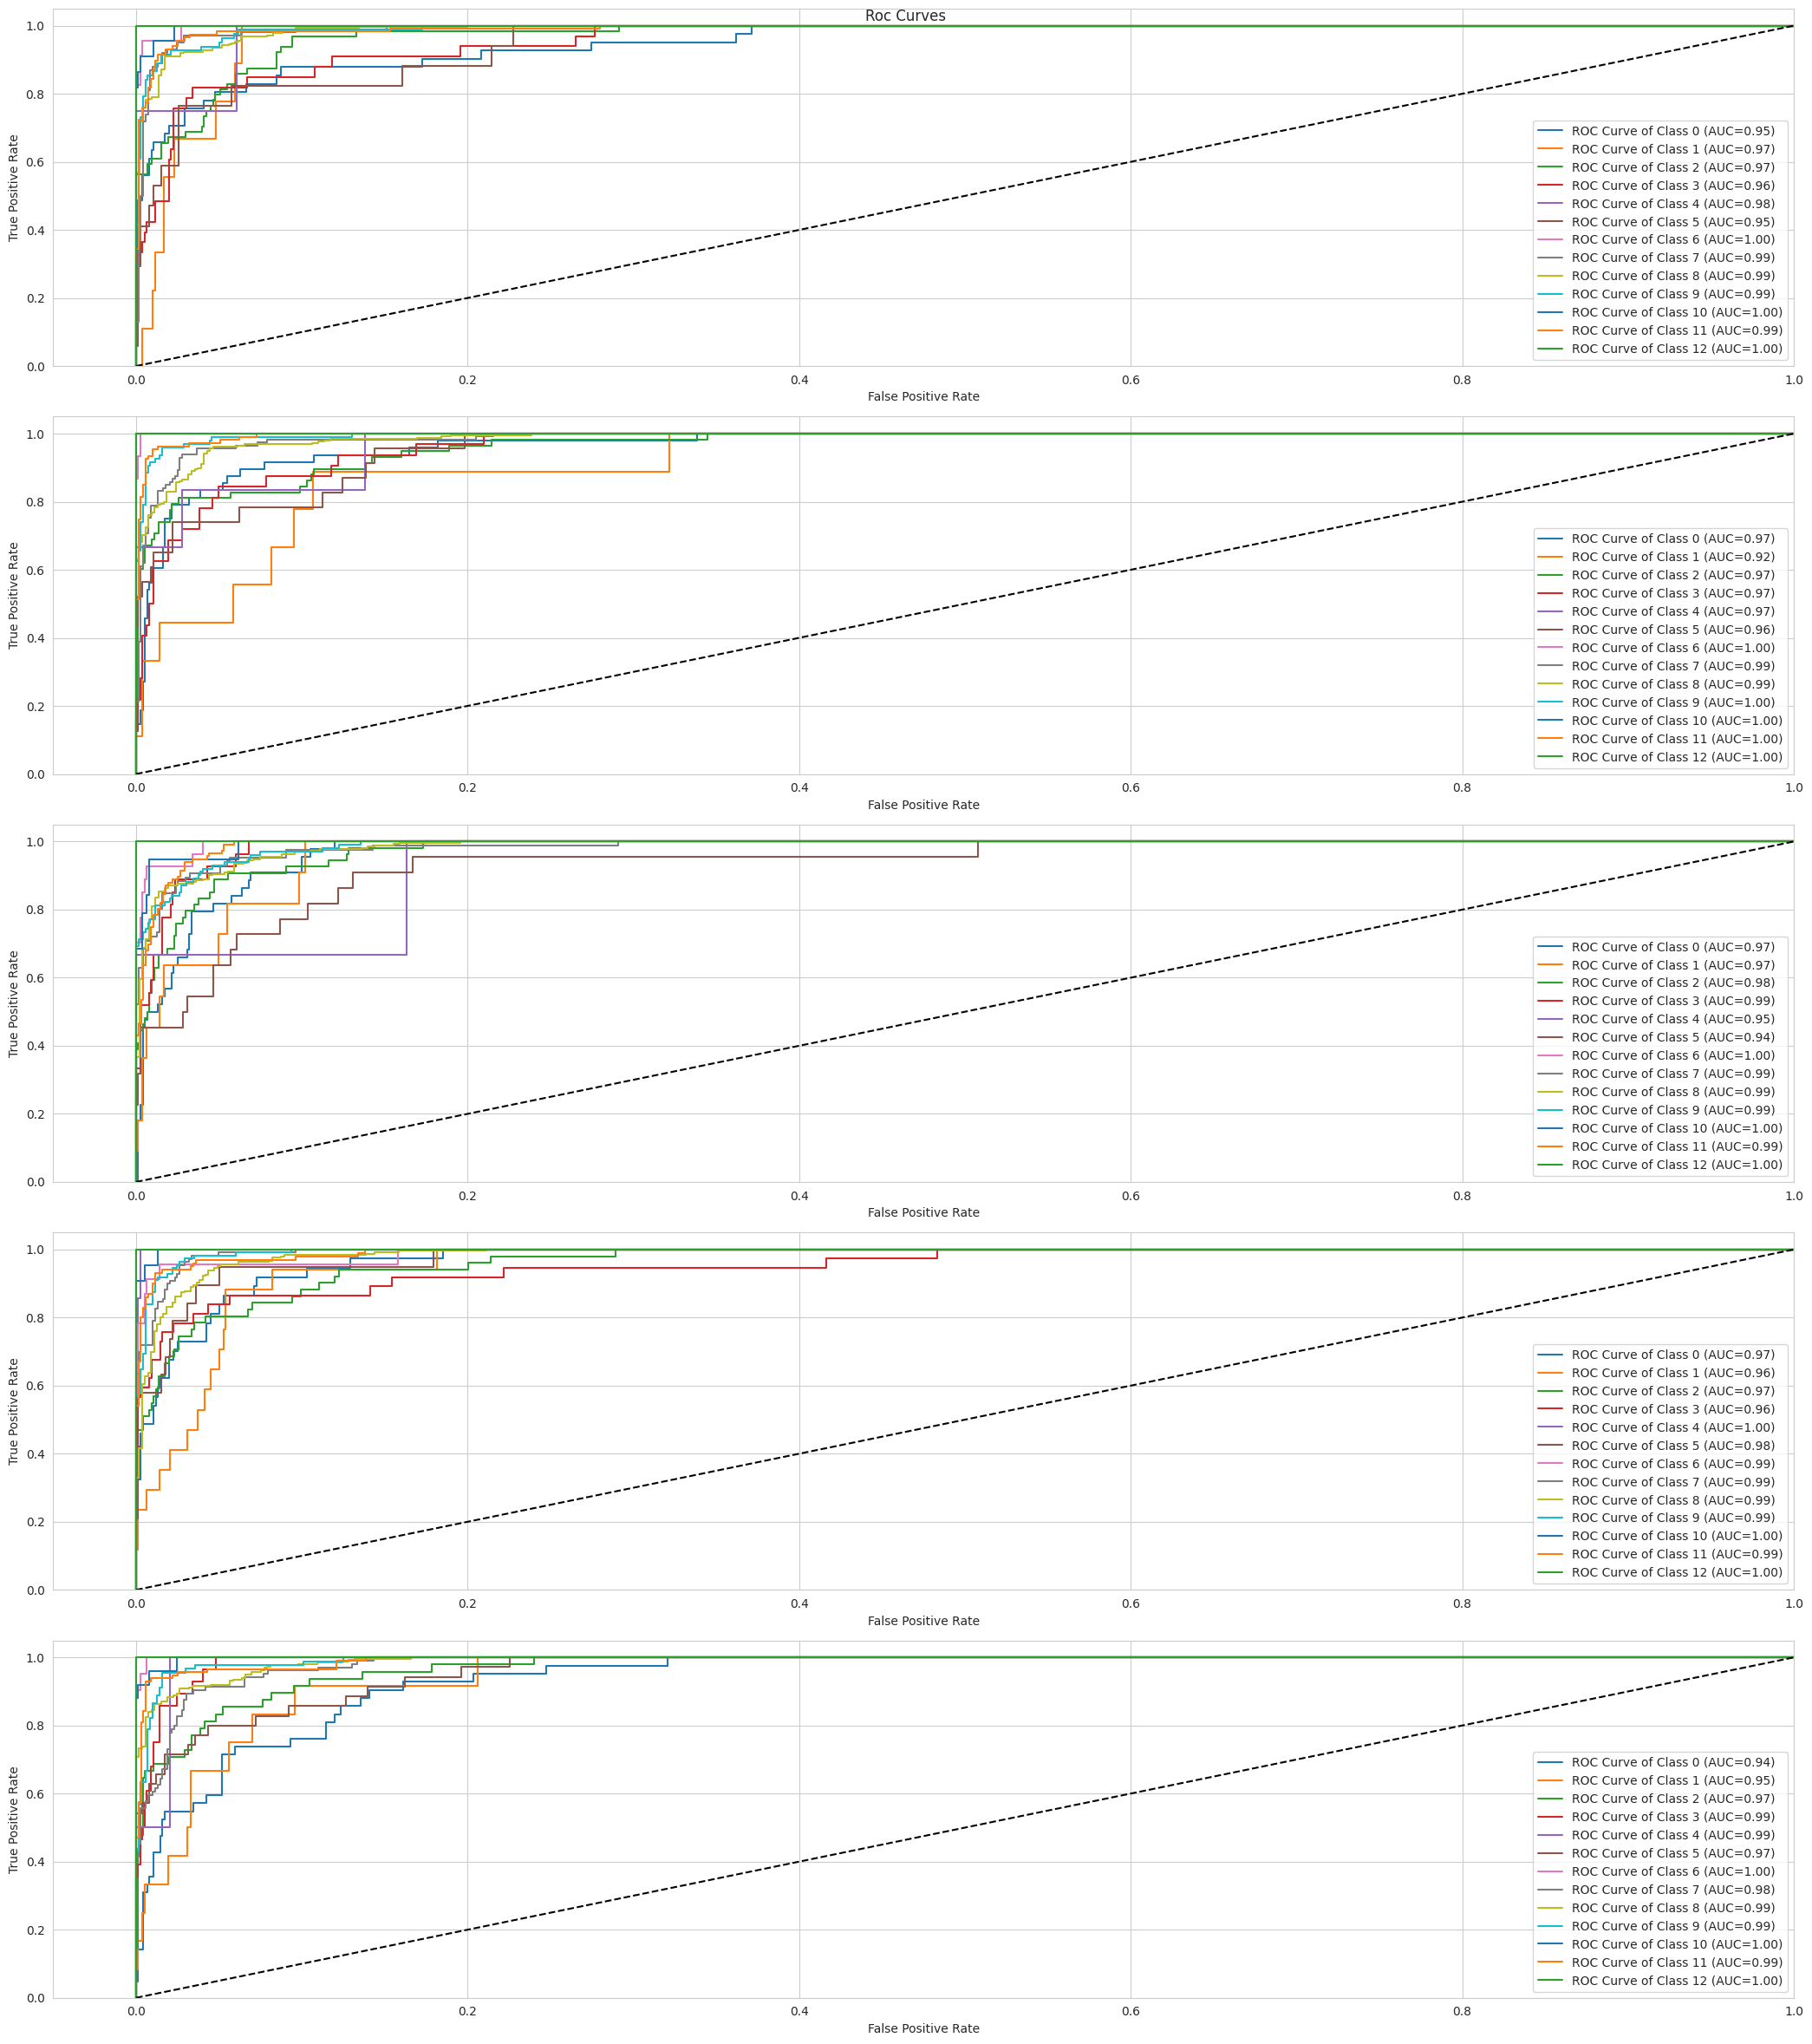

In [ ]:
n_classes = target1.unique().size

fig,axes = plt.subplots(nrows = 5 , ncols = 1 , figsize = (21,24))
for split in preds_proba.keys():
  target_binarized = label_binarize(test_ys[split] , classes = range(n_classes))
  plot_multiclass_roc(n_classes,target_binarized,preds_proba[split], ax = axes[split])
fig.suptitle("Roc Curves")
plt.tight_layout();

In [ ]:
for i in preds.keys():
  print(f'SPLIT {i}')
  print(classification_report(test_ys[i] , preds[i]))
  print('\n')

SPLIT 0
              precision    recall  f1-score   support

           0       0.86      0.59      0.70        41
           1       0.20      0.11      0.14         9
           2       0.74      0.62      0.68        64
           3       0.59      0.48      0.53        33
           4       0.75      0.75      0.75         4
           5       0.54      0.41      0.47        17
           6       0.91      0.91      0.91        23
           7       0.88      0.92      0.90       100
           8       0.87      0.97      0.91       275
           9       0.87      0.89      0.88        82
          10       1.00      0.82      0.90        22
          11       0.90      0.91      0.91       116
          12       1.00      1.00      1.00         9

    accuracy                           0.85       795
   macro avg       0.78      0.72      0.74       795
weighted avg       0.84      0.85      0.84       795



SPLIT 1
              precision    recall  f1-score   support

      

In [ ]:
print("Number of features in training data:", X_train.shape[1])

Number of features in training data: 218


# Hyperparameter Tuning

In [ ]:
param_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 250, 1),  # Number of estimators
    'learning_rate': hp.uniform('learning_rate', 0, 0.1),    # Learning rate
    'max_depth': hp.quniform('max_depth', 3, 18, 1),            # Maximum depth of trees
    'gamma': hp.uniform('gamma', 1, 9),                         # Minimum loss reduction to make a further partition
    'reg_alpha': hp.quniform('reg_alpha', 40, 180 , 1),             # L1 regularization term on weights
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),   # L2 regularization term on weights
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),  # Minimum sum of instance weight (hessian) needed in a child
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),  # Fraction of features used per tree
  # 'subsample': hp.uniform('subsample', 0.5, 1)                # Fraction of samples used per boosting round
}


In [ ]:
best = optimize(param_space, processed_features.values, target1_coded, regression=False)


Accuracy: 60.75%
AUC: 0.84
Accuracy: 60.63%
AUC: 0.79
Accuracy: 60.25%
AUC: 0.77
Accuracy: 60.88%
AUC: 0.84
Accuracy: 64.28%
AUC: 0.94
Accuracy: 63.52%
AUC: 0.92
Accuracy: 60.88%
AUC: 0.83
Accuracy: 65.16%
AUC: 0.94
Accuracy: 62.14%
AUC: 0.86
Accuracy: 62.14%
AUC: 0.90
Accuracy: 62.26%
AUC: 0.88
Accuracy: 69.43%
AUC: 0.96
Accuracy: 62.26%
AUC: 0.86
Accuracy: 60.50%
AUC: 0.83
Accuracy: 62.52%
AUC: 0.87
Accuracy: 62.64%
AUC: 0.87
Accuracy: 62.01%
AUC: 0.89
Accuracy: 62.14%
AUC: 0.86
Accuracy: 62.89%
AUC: 0.89
Accuracy: 65.79%
AUC: 0.94
Accuracy: 71.07%
AUC: 0.96
Accuracy: 69.81%
AUC: 0.96
Accuracy: 60.75%
AUC: 0.82
Accuracy: 69.69%
AUC: 0.96
Accuracy: 63.52%
AUC: 0.91
Accuracy: 65.41%
AUC: 0.93
Accuracy: 60.63%
AUC: 0.80
Accuracy: 69.43%
AUC: 0.95
Accuracy: 64.28%
AUC: 0.92
Accuracy: 64.65%
AUC: 0.93
Accuracy: 64.03%
AUC: 0.91
Accuracy: 61.13%
AUC: 0.83
Accuracy: 63.65%
AUC: 0.93
Accuracy: 65.41%
AUC: 0.94
Accuracy: 63.27%
AUC: 0.92
Accuracy: 60.88%
AUC: 0.78
Accuracy: 64.53%
AUC: 0.93
A

In [ ]:
model = XGBClassifier(
    n_estimators=int(best['n_estimators']),           # Number of boosting rounds (trees)
    learning_rate=best['learning_rate'],              # Step size shrinkage to prevent overfitting
    max_depth=int(best['max_depth']),                 # Maximum depth of trees
    gamma=best['gamma'],                              # Minimum loss reduction to make a further partition
    reg_alpha=int(best['reg_alpha']),                 # L1 regularization term on weights
    reg_lambda=best['reg_lambda'],                    # L2 regularization term on weights
    min_child_weight=int(best['min_child_weight']),   # Minimum sum of instance weight (hessian) needed in a child
    colsample_bytree=best['colsample_bytree'],        # Fraction of features used per tree
    eval_metric = 'merror',
    use_label_encoder=False                           # Set to False to avoid warning about deprecated label encoder
)


In [ ]:
fit_model = model.fit(processed_features.values , target1_coded)

In [ ]:
preds_prob = fit_model.predict_proba(processed_features.values)
training_roc = roc_auc_score(target1_coded , preds_prob , multi_class = 'ovr')
pred = fit_model.predict(processed_features.values)
training_acc = accuracy_score(target1_coded , pred)

print(f'Training ROC: {training_roc:0.2%}')
print(f'Training Accuracy: {training_acc:0.2%}')
print(classification_report(target1_coded , pred ))

Training ROC: 97.75%
Training Accuracy: 78.98%
              precision    recall  f1-score   support

           0       0.80      0.48      0.60       212
           1       0.00      0.00      0.00        58
           2       0.66      0.46      0.54       275
           3       0.76      0.26      0.39       157
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00       116
           6       0.99      0.79      0.88       109
           7       0.80      0.87      0.83       513
           8       0.73      0.99      0.84      1313
           9       0.86      0.89      0.87       480
          10       0.97      0.55      0.70       108
          11       0.86      0.94      0.90       554
          12       1.00      0.60      0.75        55

    accuracy                           0.79      3972
   macro avg       0.65      0.52      0.56      3972
weighted avg       0.76      0.79      0.76      3972



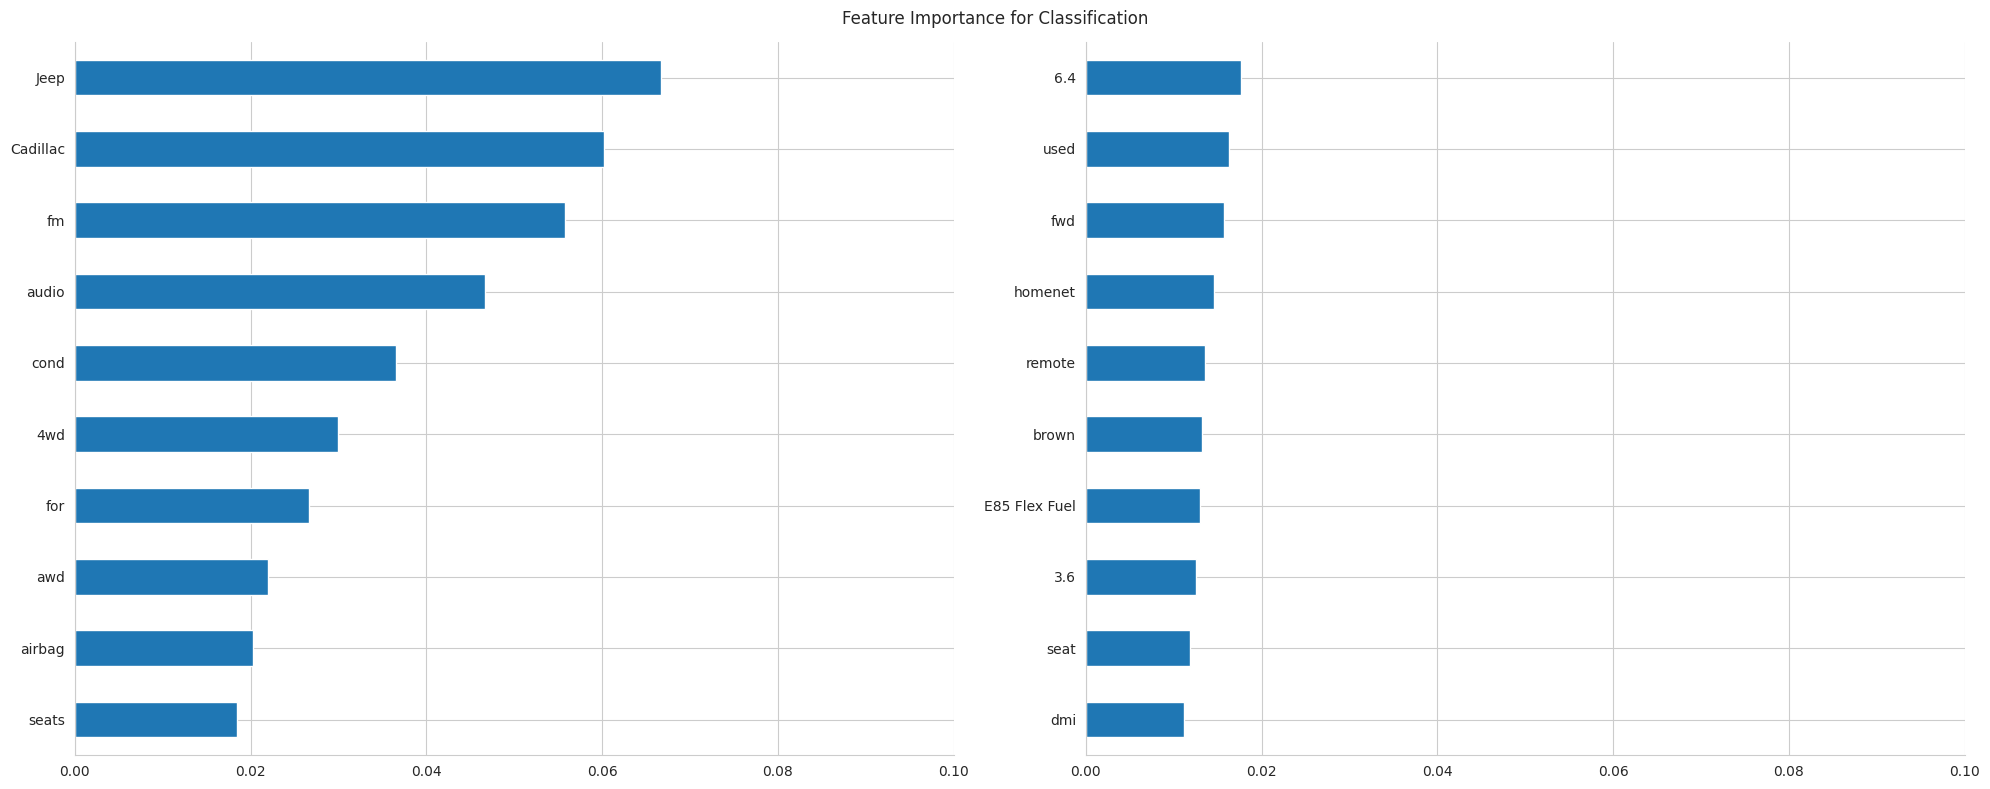

In [ ]:
feature_importance = pd.Series(fit_model.feature_importances_ , index = processed_features.columns).sort_values()
fig , axes = plt.subplots(ncols = 2 , figsize = (20,8))
feature_importance.tail(10).plot.barh(ax = axes[0])
axes[0].set_xlim(0,0.1)
feature_importance.tail(20).iloc[:10].plot.barh(ax = axes[1])
axes[1].set_xlim(0,0.1)
fig.suptitle('Feature Importance for Classification')
sns.despine()
plt.tight_layout();

In [ ]:
training_trims_pred = pd.Series(trim_encoder.inverse_transform(pred) , index = target1.index)

# Predicting Trim for Test Datset

In [ ]:
dataset_path = "/content/gdrive/My Drive/Boeing_Assignment"
csv_file = dataset_path + "/Test_Dataset.csv"
test_data = pd.read_csv(csv_file)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ListingID        1000 non-null   int64  
 1   SellerCity       1000 non-null   object 
 2   SellerIsPriv     1000 non-null   bool   
 3   SellerListSrc    1000 non-null   object 
 4   SellerName       1000 non-null   object 
 5   SellerRating     1000 non-null   float64
 6   SellerRevCnt     1000 non-null   int64  
 7   SellerState      1000 non-null   object 
 8   SellerZip        1000 non-null   int64  
 9   VehBodystyle     1000 non-null   object 
 10  VehCertified     1000 non-null   bool   
 11  VehColorExt      993 non-null    object 
 12  VehColorInt      892 non-null    object 
 13  VehDriveTrain    936 non-null    object 
 14  VehEngine        942 non-null    object 
 15  VehFeats         963 non-null    object 
 16  VehFuel          1000 non-null   object 
 17  VehHistory     

In [ ]:
###
# Create a DataFrame with NaN values for the new columns
new_columns = ['dealer_listing_price', 'vehicle_trim']
nan_data = np.empty((len(test_data), len(new_columns)))
nan_data[:] = np.nan
nan_df = pd.DataFrame(nan_data, columns=new_columns)

# Concatenate the nan_df with the test_data DataFrame
test_data = pd.concat([test_data, nan_df], axis=1)

In [ ]:
final_answers = test_data.iloc[: , -2:]
test_data = test_data.drop(final_answers.columns , axis = 1)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ListingID        1000 non-null   int64  
 1   SellerCity       1000 non-null   object 
 2   SellerIsPriv     1000 non-null   bool   
 3   SellerListSrc    1000 non-null   object 
 4   SellerName       1000 non-null   object 
 5   SellerRating     1000 non-null   float64
 6   SellerRevCnt     1000 non-null   int64  
 7   SellerState      1000 non-null   object 
 8   SellerZip        1000 non-null   int64  
 9   VehBodystyle     1000 non-null   object 
 10  VehCertified     1000 non-null   bool   
 11  VehColorExt      993 non-null    object 
 12  VehColorInt      892 non-null    object 
 13  VehDriveTrain    936 non-null    object 
 14  VehEngine        942 non-null    object 
 15  VehFeats         963 non-null    object 
 16  VehFuel          1000 non-null   object 
 17  VehHistory     

In [ ]:
final_answers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   dealer_listing_price  0 non-null      float64
 1   vehicle_trim          0 non-null      float64
dtypes: float64(2)
memory usage: 15.8 KB


In [ ]:
test_data.columns = test_data.columns.str.lower()

In [ ]:
print(test_data.columns.tolist())

['listingid', 'sellercity', 'sellerispriv', 'sellerlistsrc', 'sellername', 'sellerrating', 'sellerrevcnt', 'sellerstate', 'sellerzip', 'vehbodystyle', 'vehcertified', 'vehcolorext', 'vehcolorint', 'vehdrivetrain', 'vehengine', 'vehfeats', 'vehfuel', 'vehhistory', 'vehlistdays', 'vehmake', 'vehmileage', 'vehmodel', 'vehpricelabel', 'vehsellernotes', 'vehtype', 'vehtransmission', 'vehyear']


In [ ]:
test_features = process_testfeatures(scaler , encoder , tfidf , test_data)

In [ ]:
print("Number of features in training data:", X_train.shape[1])
print("Number of features in test data:", test_features.shape[1])


Number of features in training data: 218
Number of features in test data: 218


In [ ]:
pred_labels_test = fit_model.predict(test_features.values)
pred_proba_test = pd.DataFrame(fit_model.predict_proba(test_features.values) , index = test_features.index)
pred_trims_test = pd.Series(trim_encoder.inverse_transform(pred_labels_test) , index = test_features.index)

In [ ]:
trim_proportions = pd.DataFrame({'Training' : target1.value_counts()/target1.size ,
                                 'Testing' : pred_trims_test.value_counts()/pred_trims_test.size})
trim_proprtions = trim_proportions.fillna(0)
trim_proprtions['Difference'] = abs(trim_proprtions['Training'] - trim_proportions['Testing'])
trim_proportions.sort_values('Training' , ascending = False)

,Training,Testing
limited,0.330564,0.413
premium,0.139476,0.174
laredo,0.129154,0.131
luxury,0.120846,0.134
Overland,0.069235,0.063
Altitude,0.053374,0.031
Summit,0.039527,0.012
Trailhawk,0.029204,NaN
base,0.027442,0.022
platinum,0.027190,0.014


# Modeling Dealer Listing Price


In [ ]:
onehot_trim = pd.get_dummies(target1)
price_features = pd.concat([processed_features , onehot_trim] ,  axis = 1)
price_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3972 entries, 4777 to 8604205
Columns: 231 entries, sellerrating to srt
dtypes: float64(206), int64(12), uint8(13)
memory usage: 6.8 MB


In [ ]:
cv = KFold(shuffle = True , random_state = 20).split(price_features.values , target2.values)

r2_scores = dict()
preds = dict()
scores_dict = dict()
test_Xs = dict()
test_ys = dict()

for i , (train_index , test_index ) in enumerate(cv):
  X_train = price_features.values[train_index]
  y_train = target2.values[train_index]

  test_Xs[i] = price_features.values[test_index]
  test_ys[i] = target2.values[test_index]

  model = XGBRegressor()
  fit_model = model.fit(X_train , y_train)

  preds[i] = fit_model.predict(test_Xs[i])
  r2_scores [i] = r2_score(test_ys[i] , preds[i] )

  scores_dict[i] = {'rmse' : np.sqrt(mean_squared_error(test_ys[i] , preds[i])),
                    'mae'  : mean_absolute_error(test_ys[i] , preds[i]),
                    'medae': median_absolute_error(test_ys[i] , preds[i])
  }


In [ ]:
[print(f'Fold {i} , R2 Score = {score}') for i,score in enumerate(r2_scores.values())];

Fold 0 , R2 Score = 0.9328693201558
Fold 1 , R2 Score = 0.8902642679677285
Fold 2 , R2 Score = 0.9292302032499078
Fold 3 , R2 Score = 0.9211234704667519
Fold 4 , R2 Score = 0.9337891957084657


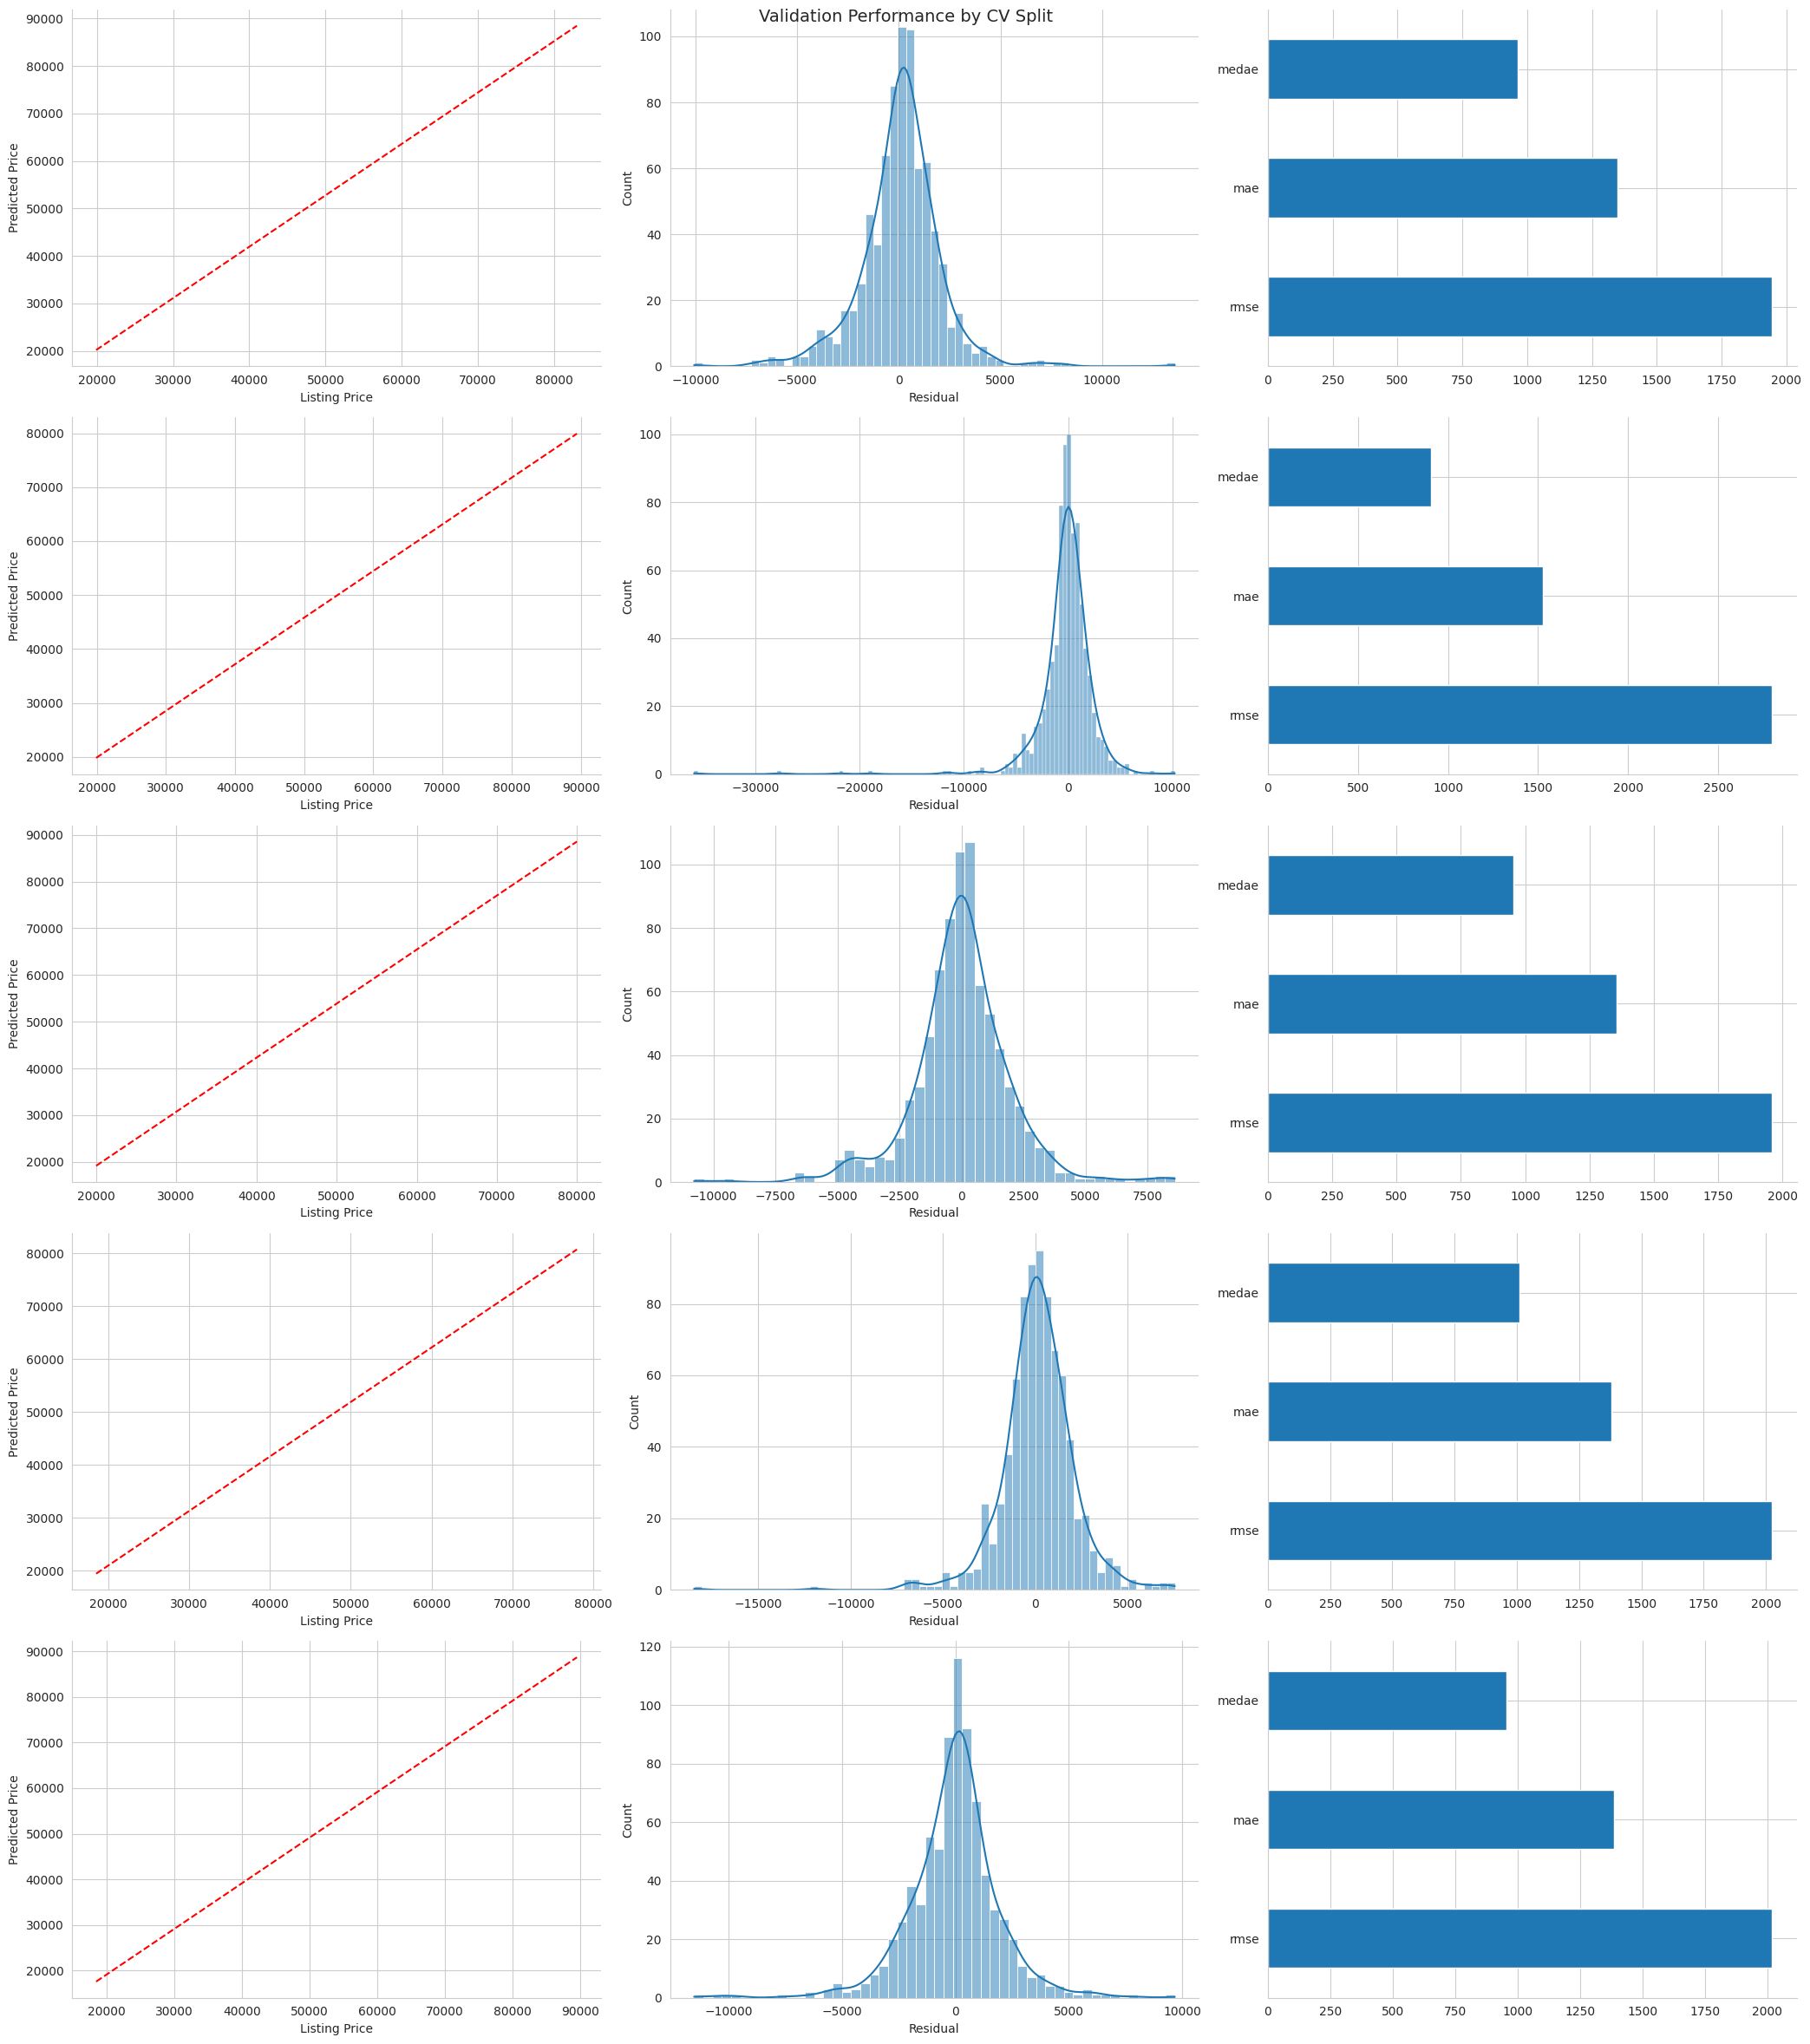

In [ ]:
fig,axes = plt.subplots(nrows = 5 , ncols = 3 , figsize = (21,24))

for split in r2_scores.keys():
  sns.scatterplot(x = test_ys[split], ax = axes[split,0])
  axes[split,0].plot([test_ys[split].min() , test_ys[split].max()] , [preds[split].min() , preds[split].max()] , c = 'red' , linestyle = 'dashed')
  axes[split,0].set_xlabel('Listing Price')
  axes[split,0].set_ylabel('Predicted Price')

  residuals = preds[split] - test_ys[split]
  sns.histplot(residuals, ax = axes[split,1] , kde = True)
  axes[split,1].set_xlabel('Residual')

  pd.Series(scores_dict[split]).plot.barh(ax = axes[split,2])

fig.suptitle('Validation Performance by CV Split' , fontsize = 14)
sns.despine()
plt.tight_layout();

# Hyperparameter Tuning


In [ ]:
param_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 250, 1),  # Number of estimators
    'learning_rate': hp.uniform('learning_rate', 0, 0.1),    # Learning rate
    'max_depth': hp.quniform('max_depth', 3, 18, 1),            # Maximum depth of trees
    'gamma': hp.uniform('gamma', 1, 9),                         # Minimum loss reduction to make a further partition
    'reg_alpha': hp.quniform('reg_alpha', 40, 180 , 1),             # L1 regularization term on weights
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),   # L2 regularization term on weights
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),  # Minimum sum of instance weight (hessian) needed in a child
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),  # Fraction of features used per tree
  # 'subsample': hp.uniform('subsample', 0.5, 1)                # Fraction of samples used per boosting round
}


In [ ]:
best = optimize(param_space, price_features.values, target2.values, regression=True)

RMSE: 3890.0844
R2: 0.7005
RMSE: 1942.0133
R2: 0.9254
RMSE: 1871.2534
R2: 0.9307
RMSE: 1862.6595
R2: 0.9313
RMSE: 1828.2705
R2: 0.9338
RMSE: 1779.6418
R2: 0.9373
RMSE: 1811.4778
R2: 0.9351
RMSE: 1942.0234
R2: 0.9254
RMSE: 31364.2732
R2: -18.4681
RMSE: 4472.0991
R2: 0.6042
RMSE: 1763.9160
R2: 0.9384
RMSE: 1740.7445
R2: 0.9400
RMSE: 1760.2581
R2: 0.9387
RMSE: 1828.2801
R2: 0.9338
RMSE: 1778.4484
R2: 0.9374
RMSE: 19740.5003
R2: -6.7120
RMSE: 30020.7233
R2: -16.8359
RMSE: 1851.6177
R2: 0.9321
RMSE: 1856.6254
R2: 0.9318
RMSE: 1828.3989
R2: 0.9338
RMSE: 1741.4903
R2: 0.9400
RMSE: 1718.0598
R2: 0.9416
RMSE: 1731.3766
R2: 0.9407
RMSE: 1745.8062
R2: 0.9397
RMSE: 1772.6427
R2: 0.9378
RMSE: 1731.6109
R2: 0.9407
RMSE: 1765.0089
R2: 0.9383
RMSE: 1710.1029
R2: 0.9421
RMSE: 1721.9173
R2: 0.9413
RMSE: 1832.6867
R2: 0.9335
RMSE: 1969.9375
R2: 0.9232
RMSE: 1825.7394
R2: 0.9340
RMSE: 1765.1523
R2: 0.9383
RMSE: 3353.5310
R2: 0.7774
RMSE: 1827.1709
R2: 0.9339
RMSE: 1831.5354
R2: 0.9336
RMSE: 1754.8220
R2: 

In [ ]:
best

{'colsample_bytree': 0.5631616854309242,
 'gamma': 5.13235713705207,
 'learning_rate': 0.08203773519597136,
 'max_depth': 10.0,
 'min_child_weight': 4.0,
 'n_estimators': 158.0,
 'reg_alpha': 76.0,
 'reg_lambda': 0.6858791580960825}

In [ ]:
model = XGBRegressor(
    n_estimators=int(best['n_estimators']),           # Number of boosting rounds (trees)
    learning_rate=best['learning_rate'],              # Step size shrinkage to prevent overfitting
    max_depth=int(best['max_depth']),                 # Maximum depth of trees
    gamma=best['gamma'],                              # Minimum loss reduction to make a further partition
    reg_alpha=int(best['reg_alpha']),                 # L1 regularization term on weights
    reg_lambda=best['reg_lambda'],                    # L2 regularization term on weights
    min_child_weight=int(best['min_child_weight']),   # Minimum sum of instance weight (hessian) needed in a child
    colsample_bytree=best['colsample_bytree']        # Fraction of features used per tree
)


In [ ]:
fit_model = model.fit(price_features.values , target2.values)

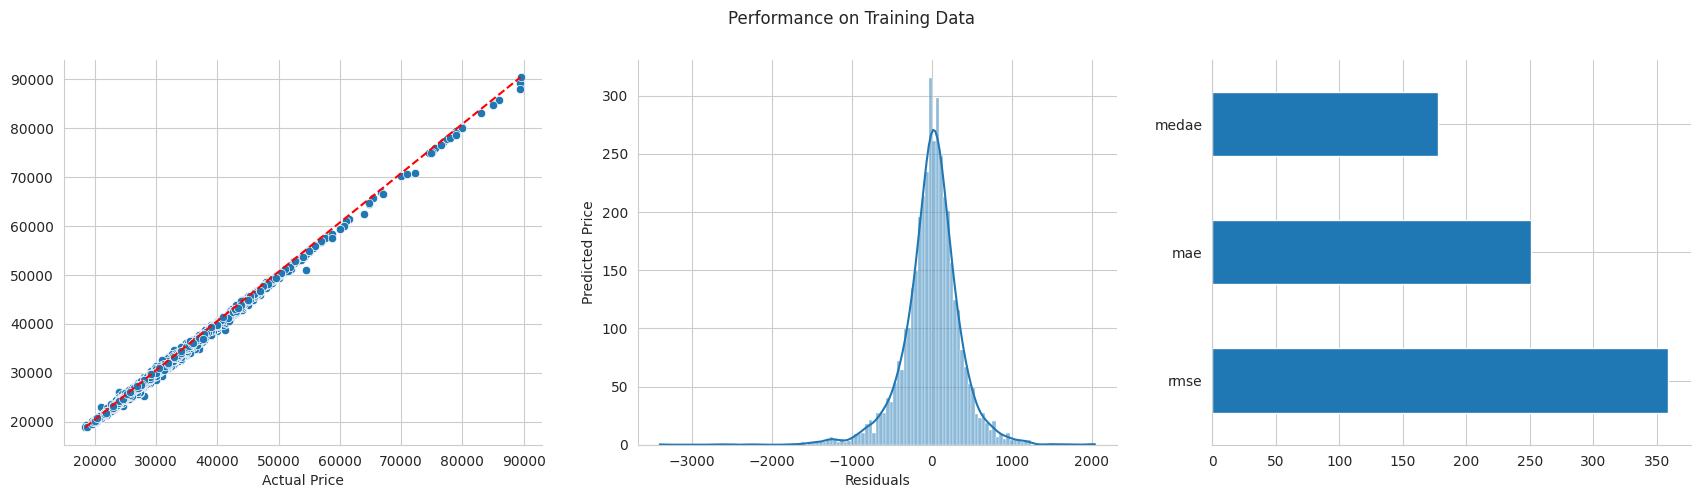

In [ ]:
training_pred = fit_model.predict(price_features)
fig, axes = plt.subplots(ncols=3, figsize= (21,5))
sns.scatterplot(x=target2.values, y = training_pred, ax = axes[0])
axes[0].plot([target2.min(), target2.max()], [training_pred.min(), training_pred.max()],
c='red', linestyle='dashed')

axes[0].set_xlabel('Actual Price')
axes[1].set_ylabel('Predicted Price')

res = training_pred - target2.values
sns.histplot (res, kde=True, ax=axes[1])
axes[1].set_xlabel('Residuals')

scores = dict(rmse = np.sqrt(mean_squared_error(target2.values, training_pred)),
              mae = mean_absolute_error(target2.values, training_pred),
              medae = median_absolute_error(target2.values, training_pred))
pd.Series (scores).plot.barh(ax=axes[2])

sns.despine()
fig.suptitle('Performance on Training Data');

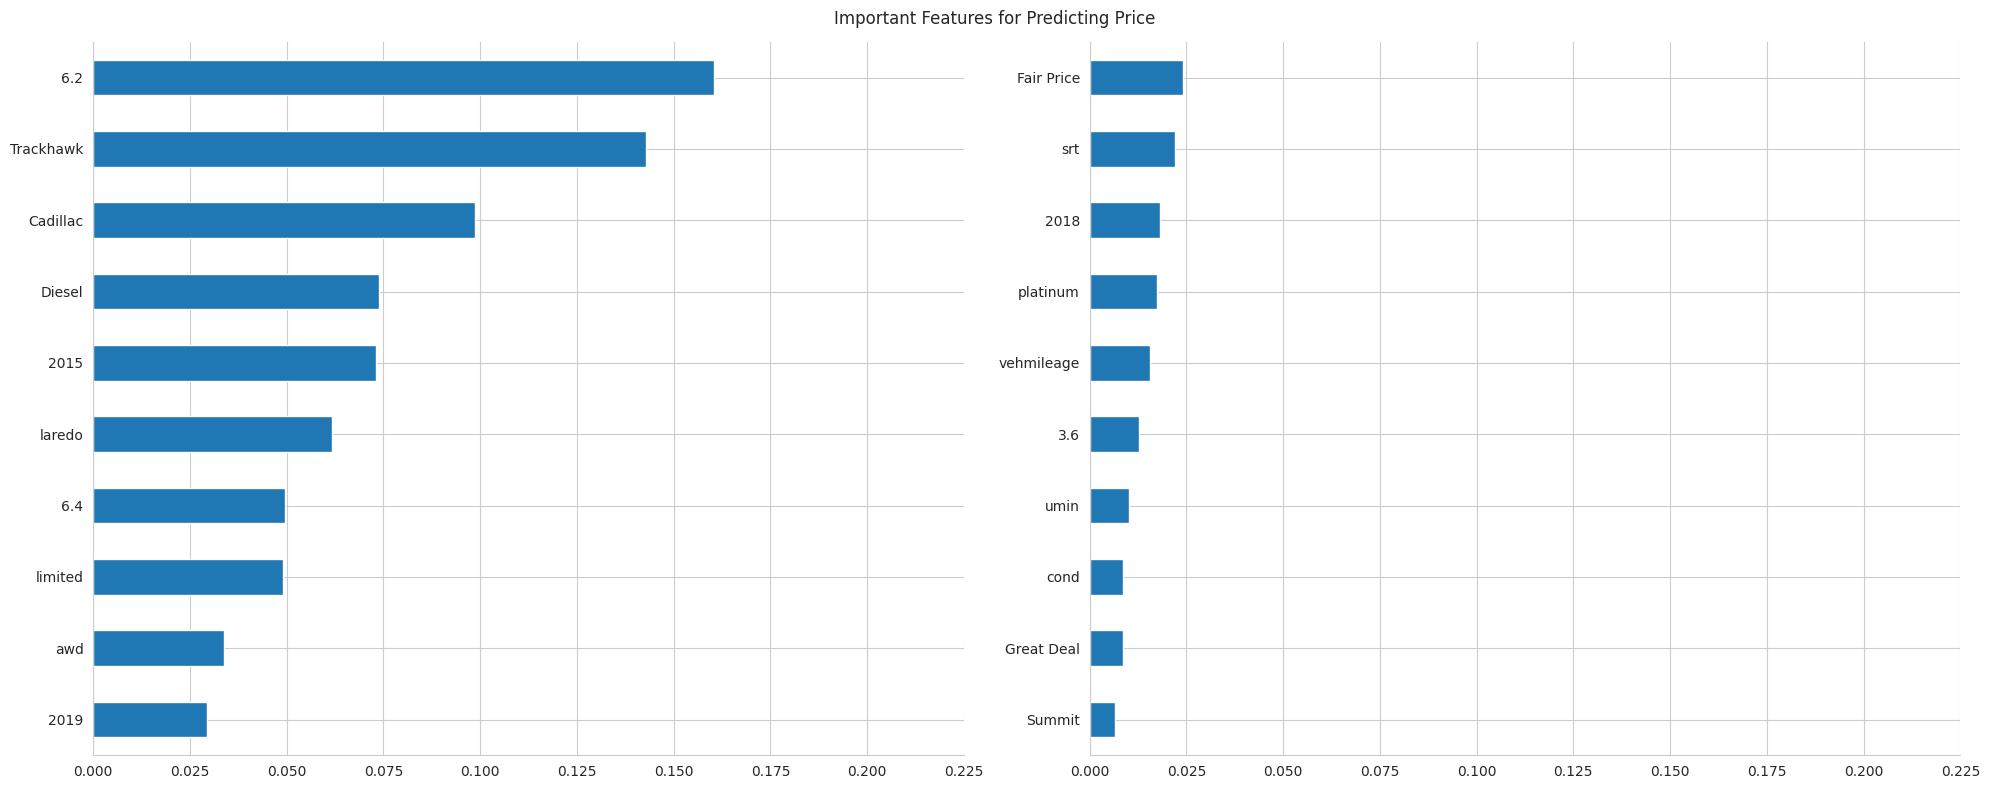

In [ ]:
feature_importance = fit_model.feature_importances_
feature_importance = pd.Series(feature_importance, index=price_features.columns).sort_values ()
fig, axes = plt.subplots(ncols=2, figsize=(20,8))
feature_importance.tail(10).plot.barh(ax=axes[0])
axes[0].set_xlim(0, 0.225)
feature_importance.tail(20).iloc[:10].plot.barh(ax=axes[1])
axes[1].set_xlim(0, 0.225)
fig.suptitle('Important Features for Predicting Price')
sns.despine()
plt.tight_layout();

# Predict Price for Test Dataset

In [ ]:
(test_features.columns == price_features.columns[:test_features.columns.size]).mean()

1.0

In [ ]:
test_price_features = test_features.copy()
for i in range (217, 230):
    colname = price_features.columns[i]
    newcol = pd.Series(0, index = test_features.index, name=colname)
    test_price_features = pd.concat([test_price_features, newcol], axis=1)

In [ ]:
exp_prices = dict()
for i in range(217, 230) :
    temp_feats = test_price_features.copy()
    temp_feats.iloc[:, i] = 1
    exp_prices[i] = fit_model.predict(temp_feats)

In [ ]:
exp_prices = pd.DataFrame(exp_prices, index=test_features.index)

In [ ]:
pred_prices_test = pd.Series(index = test_features.index, dtype=float)
for idx in test_features.index:
    pred_prices_test.loc[idx] = (exp_prices.loc[idx, :].values * pred_proba_test.loc[idx, :].values).sum()

In [ ]:
desc_stats = pd.DataFrame({'Training': target2.describe(),
                           'Testing': pred_prices_test.describe()})

desc_stats

,Training,Testing
count,3972.000000,1000.000000
mean,32153.833082,33006.420145
std,7686.297093,5150.889913
min,18450.000000,23424.074219
25%,26795.000000,28983.344238
50%,30999.000000,32195.407227
75%,35922.000000,36611.809570
max,89500.000000,53257.750000


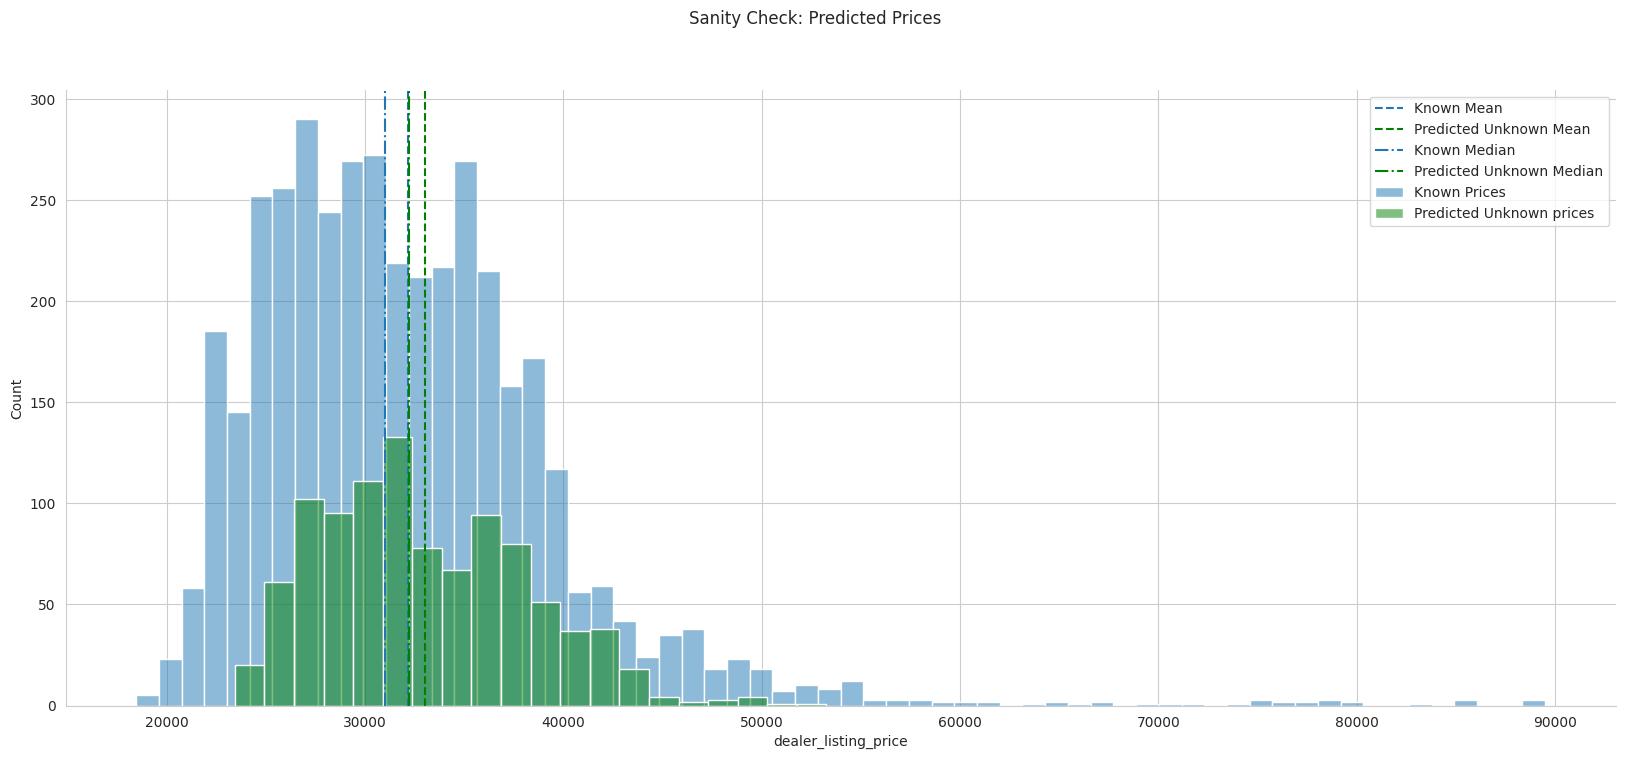

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.histplot(target2, ax=ax, label='Known Prices', alpha=0.5)
sns.histplot(pred_prices_test, ax=ax, label='Predicted Unknown prices', color='green', alpha=0.5)
ax.axvline(target2.mean(), linestyle='dashed',  label= 'Known Mean')
ax.axvline(pred_prices_test.mean(), linestyle = 'dashed', color='green', label='Predicted Unknown Mean')
ax.axvline(target2.median(), linestyle = '-.', label= 'Known Median')
ax.axvline(pred_prices_test.median(), linestyle='-.', color='green', label='Predicted Unknown Median')
plt.legend()
sns.despine()
fig.suptitle('Sanity Check: Predicted Prices');

# Metrics on Test Data

In [ ]:
test_roc = roc_auc_score(final_answers['vehicle_trim'],
                         pred_proba_test,
                         multi_class = 'ovr' )
test_acc = accuracy_score(final_answers['vehicle_trim'],
                         pred_trims_test)
print(f'AUC Score on Test set : {test_roc:.2%}')
print(f'Accuracy on Test Set : {test_acc:.2%}')

ValueError: ignored

In [ ]:
print(classification_report(final_answers['vehicle_trim'],
                           pred_trims_test))

In [ ]:
confmat = confusion_matrix(final answers['vehicle_trim'],
                          pred_trims_test)
fig, ax = plt. subplots(figsize=(20,8))
sns.heatmap(confmat, annot=True, cmap='YlGnBu', center=150, ax=ax)
ax.invert_yaxis();

In [ ]:
test_rmse = np.sqrt(mean_squared_error(final_answers['dealer_listing_price'],
                                      pred_prices_test))
test_mae = mean_absolute_error(final_answers['dealer_listing_price'],
                              pred_prices_test)
test_medae = median_absolute_error(final_answers['dealer_listing_price'],
                                  pred_prices_test)
test_r2 = r2_score(final_answers['dealer_listing_price'],
                  pred_prices_test)
test_res = pred_prices_test - final_answers['dealer_listing_price']

In [ ]:
print(f'RMSE on Test Set: {test_rmse:.2f}')
print(f'MAE on Test Set: {test_mae:.2f}')
print(f'Median AE on Test Set: {test_medae:.2f}')
print(f'r2 on Test Set: {test_r2:.2%}')

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(21,5))
sns.scatterplot(x=final_answers['dealer_listing_price'].values, y=pred_prices_test, ax=axes[0])
sns.lineplot(x=final_answers['dealer_listing_price'],
              y=final answers['dealer_listing_price'],
              ax=axes[0], color='red', linestyle='dashed')

axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')

sns.histplot(test_res, kde=True, ax=axes[1])
axes[1].set_xlabel('Residuals')

pd.Series({'RMSE': test_rmse,
           'MAE': test_mae,
           'Median AE':test_medae}).plot.barh(ax=axes[2])

fig.suptitle(f'Regression on Test Set (R2: (test_r2:.2%})', fontsize=16)
sns.despine();

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20,15))
sns.histplot(final_answers['dealer_listing_price'], kde=True, label='Actual Values', ax=axes[0])
sns.histplot(pred prices_test, kde=True, color='green', label='Predicted values', ax=axes[1])
axes[1].invert_yaxis()
fig.legend()
sns.despine()
plt.subplots_adjust(hspace=0, top=0.95)
fig.suptitle('Distribution of Actual vs. Predicted Values', fontsize=16);

In [ ]:
plt.figure(figsize=(20,8))
sns.histplot(final_answers['dealer_listing_price'], kde=True, label='Actual Values')
sns.histplot(pred_prices_test, kde=True, color='green', alpha=0.35, label='Predicted values')
plt.title('Overlapping', fontsize=16)
plt.legend ()
sns.despine();

# Saving Prediction as CSV

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   listingid        1000 non-null   int64  
 1   sellercity       1000 non-null   object 
 2   sellerispriv     1000 non-null   bool   
 3   sellerlistsrc    1000 non-null   object 
 4   sellername       1000 non-null   object 
 5   sellerrating     1000 non-null   float64
 6   sellerrevcnt     1000 non-null   int64  
 7   sellerstate      1000 non-null   object 
 8   sellerzip        1000 non-null   int64  
 9   vehbodystyle     1000 non-null   object 
 10  vehcertified     1000 non-null   bool   
 11  vehcolorext      993 non-null    object 
 12  vehcolorint      892 non-null    object 
 13  vehdrivetrain    936 non-null    object 
 14  vehengine        942 non-null    object 
 15  vehfeats         963 non-null    object 
 16  vehfuel          1000 non-null   object 
 17  vehhistory     

In [ ]:
# Assuming 'test_data' contains the 'ListingID' column
final_predictions = pd.concat([test_data['listingid'], pred_trims_test, pred_prices_test], axis=1)
final_predictions.columns = ['ListingID', 'vehicle_trim', 'dealer_listing_price']

# Convert 'dealer_listing_price' to integer
final_predictions['dealer_listing_price'] = final_predictions['dealer_listing_price'].astype(int)

# Save to CSV
final_predictions.to_csv('test_results.csv', index=False)
